<a href="https://colab.research.google.com/github/Kevin-McIsaac/Predictive_Applications/blob/master/Retention_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Leaky Bucket Membership Model

Consider a leaky bucket with holes all the way up its sides.   As you add water it starts to leak out and as the level rises the number of leaks increase until the amount leaking out equals the amount being poured in. At this point the level reaches a steady state.  If the inflow increases the level slowly increases until it gets to a new steady state. If the inflow decreases the level falls until it get to the new, lower steady state. 

At COMPANY : <img  style="float:right;width:250px;" src="http://www.clv-calculator.com/wp-content/uploads/2014/11/leaky-bucket-theory.png"/>
1. new member sales are the inflows, 
2. customers churning at the end of a membership are the leaks, 
3. the total active members is the level. 

There are two ways to increase the level in the bucket (total active members):
1. Add water more quickly (i.e., increase monthly sales)
2. Plug up some holes (i.e., reduce churn)

## Overview

This analysis is based on an Netsuit extraction of all membership data as at 14 June 2016. This includes all memberships sales from Jan 2013 and any historical membership data for members who were active at that data. For our purposes this means our earliest useful date is Jan 2012.

COMPANY is interested in why membership have declined, especially in China.  To understand this we start by looking at member data at the organisational level before examining specficic segments such as country or employee. Based on the Leaky Bucket model, we examine the data in three ways
* _New Member sales_ (water going into the bucket): This is the number of members with their first membership in a period. This is calcualted from MEMBER_SINCE for historical data or the first START_DATE for data since Netsuite went live.
* _Churn Rate_ (water leaking out): This is the percentage of a cohort that did not renew at the end of year 1, 2, 3 etc.  Renewal rate is 1 - Churn . 
* _total active members_ (water level). All memberships that are active during a specific period.


We use the following terms in a specific way:
* _Cohort_ members who joined in a common period, i.e., month, quarter or year. Churn and retention are based on Cohorts. 
* _Segment_ a sub-set of members with a common attributes, i.e., Country, Employee

Note that Cohort are a slice in time and Segments are a slice by some attribute.

In [0]:
# Initialisation cell
import graphlab as gl
gl.canvas.set_target('ipynb')
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

import matplotlib.dates as mdates

import tools as tl
import shifted_beta_geometric as sbg

label_size = 16
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.titlesize'] = 1.5 * label_size
plt.rcParams['axes.titleweight'] = 'bold'

members = gl.SFrame('Data/Membership')

This non-commercial license of GraphLab Create is assigned to kevin.mcisaac@gmail.com and will expire on November 06, 2016. For commercial licensing options, visit https://dato.com/buy/.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1467086779.log


To gain an understand of the membership sales we start by looking at all the data before we examine any Segment in detail. We first look at New Member Sales to understand the inflows, then the Churn to understand the outflows then we look at the Total Active Members to understand the level.

## New Member Sales

The plot below shows the number of New Member Sales per quarter for the entire organisation. 


**Note:** 
* Dates are the start of the quarter not the end.
* Jan 2012 figures may be low depending on the import cut-off processes.
* Apr 2016 figures do not reflect the full sales for the quarter as the data was taken as of 14 June 2014.

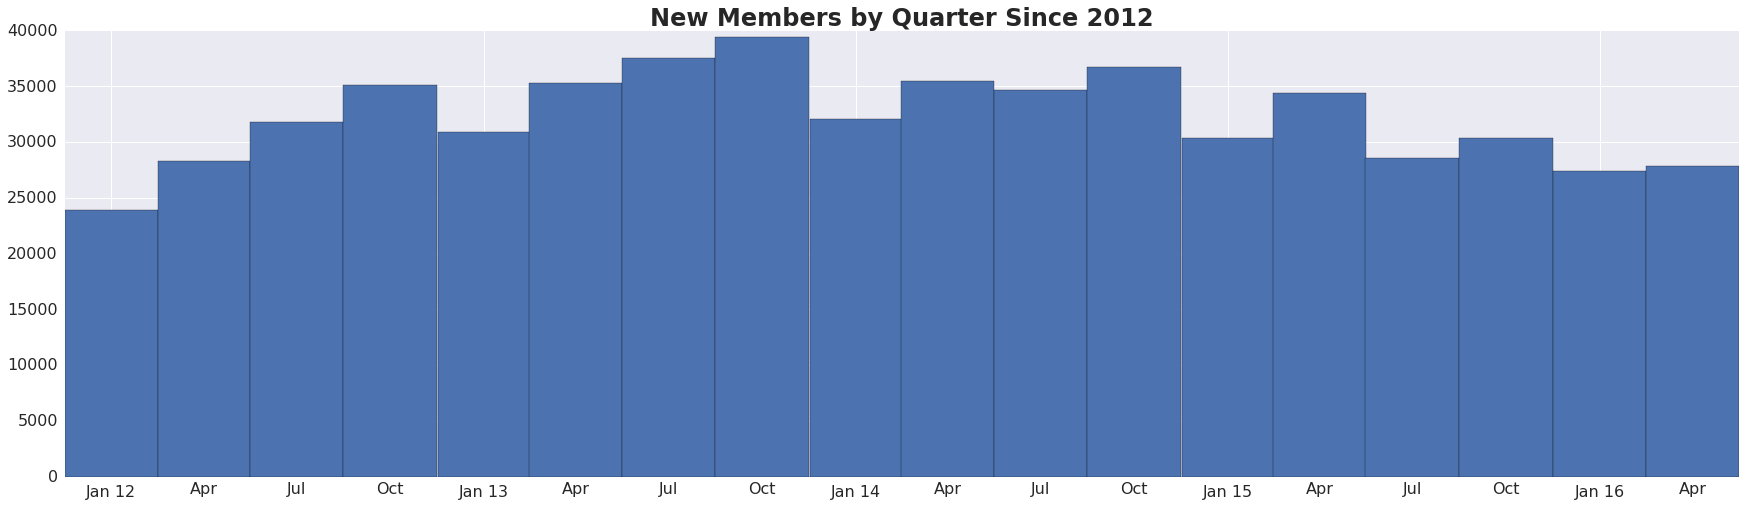

In [0]:
reload(tl)
tl.plot_new_sales(members, dt.datetime(2012, 1, 1), window=3, title="New Members by Quarter Since 2012")

From this we can see:
* An annual quarter over quarter ramp up though the yearfor 2012 - 2014. This pattern breaks down in 2015.
* Since the April 2014 quarter, year over year quarterly sales have declined. For example the Oct 2015 quarter is 20% below the Oct 2013 quarter
* Jan 2016 figures are below Jan 13 but above Jan 12

**Questions:**  Does this data look correct?
* Do the quarterly sales volumes look correct?
* Does the seasonal rampup in 2012, 2013 and 2014 look correct?
 * Do you expect this quarterly ramp up.
 * Why did it not happen in 2014, 2015?
* Have sales declined in last couple of years

## Churn

The bar chart below shows the renewals of members for the 2012 cohort. The churn rate is written at the top of each bar. In the title we sum the total memberships over the available data for that cohort and show its percentage of the first year sales. These two summary statistics, while crude, enable a basic comparison between different cohorts.

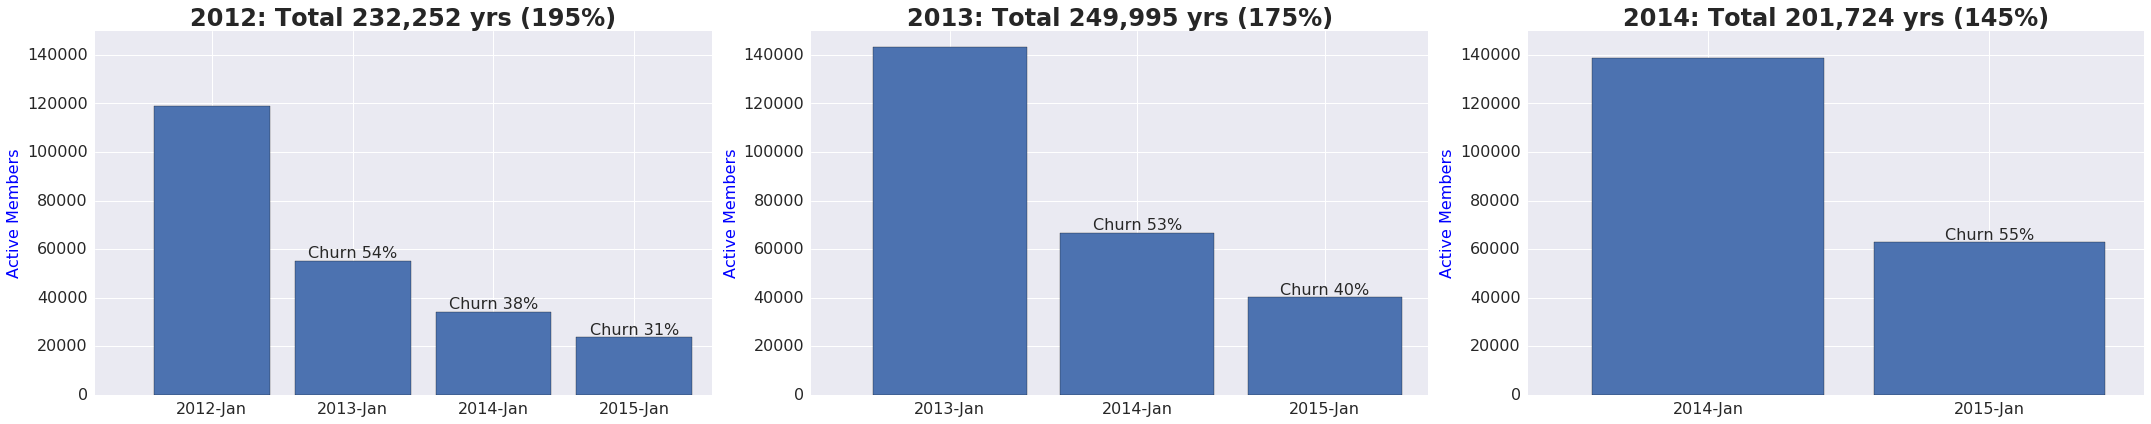

In [0]:
years = [2012, 2013, 2014]

fig, axes = plt.subplots(1, len(years), figsize=(30,6))
for ax, year in zip(axes, years):
    start =dt.datetime(year, 1, 1)
    r = tl.retention(members, 'MEMBER_SINCE', 'END_DATE',start , window=12)    
    tl.plot_retention(r, "{:%Y}".format(start), ax)
    ax.set_ylim(0,150000)
plt.tight_layout()

From these charts we note:
* About 55% of members are lost directly after their first year, i.e., COMPANY has a very leaky bucket.
* Churn reduces to about 40% at the end of second year and around 30% at the end of the third.
* Based on a limited number of years of member data these figures have not changed significantly over the last few years 

As a further test, we look at the churn rate in 2012 for each quarter

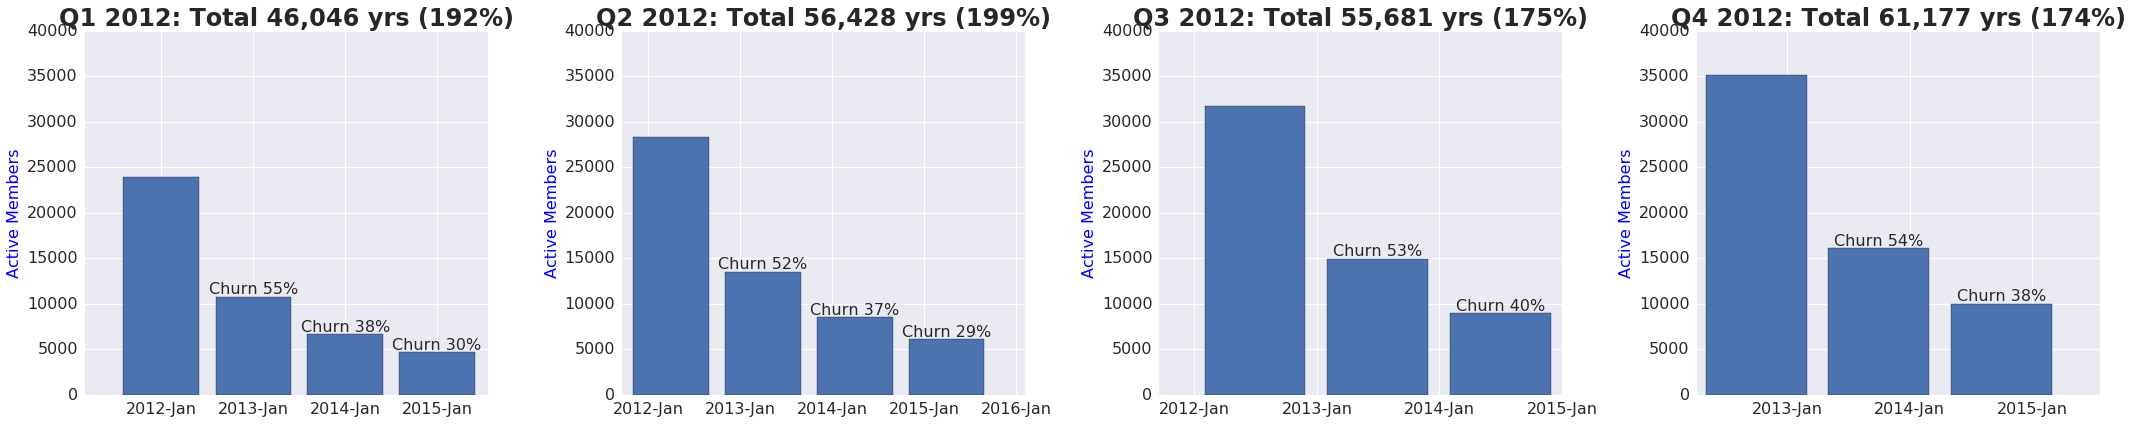

In [0]:
year = 2012
quarters = range(1,5)
fig, axes = plt.subplots(1, len(quarters), figsize=(30,6))

for ax,  quarter in zip(axes, quarters):
    start =dt.datetime(year, (quarter-1)*3+1, 1)
    r = tl.retention(members, 'MEMBER_SINCE', 'END_DATE',start , window=3)    
    tl.plot_retention(r, "Q{} {:%Y}".format(quarter, start), ax)
    ax.set_ylim(0,40000)
    
plt.tight_layout()

From this we conclude the churn rate is generally constant though out 2012.  Next we exmaine the Q1 churn rate for 2012 - 2024

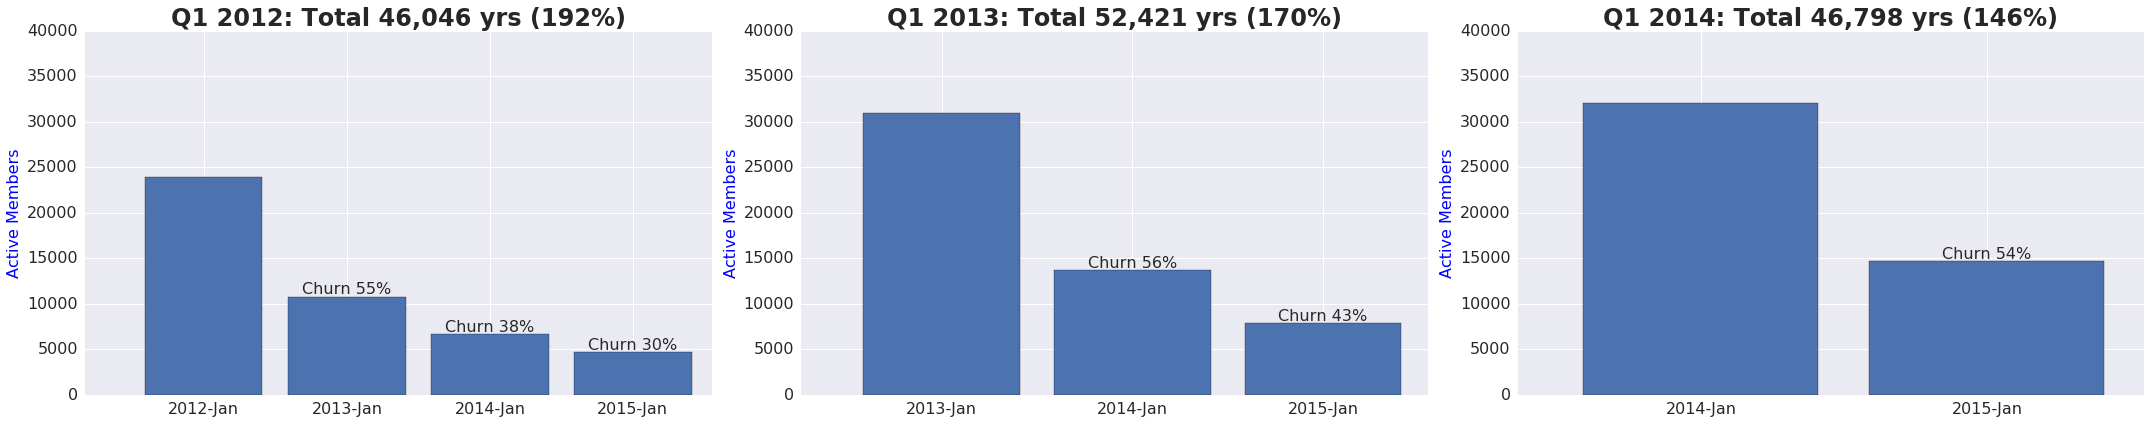

In [0]:
years = [2012, 2013, 2014]
fig, axes = plt.subplots(1, len(years), figsize=(30,6))

for ax,  year in zip(axes, years):
    start =dt.datetime(year, 1, 1)
    r = tl.retention(members, 'MEMBER_SINCE', 'END_DATE',start , window=3)    
    tl.plot_retention(r, "Q1 {:%Y}".format(start), ax)
    ax.set_ylim(0,40000)
    
plt.tight_layout()

Again the Churn Rates do not vary greatly over time. That is, we see no evidence of a significant drop in retention in  recent years

**Note:** An interesting in features of the Churn Rate is it declines over time, i.e., 55%, 38%, 30%. Many marketers believe this is caused by customers becoming more familiar with the value proposition and hence being more loyal. There is an alternative explaination that the intrinsic retention rate for each new customer is different and over time the less likely to by drop out, leaving the more loyal. 

## Total Active Members

The plot below shows the total active members by quarter, i.e., New Member sales + Renewals. In this plot:
* Each member cohort (i.e., new members in a quarter) are a seperate colour. This shows 
 * how each cohort churns over time 
 * how these add up to form Total Active Members for a quarter
* The large slice at the bottom are members who joined before Jan 2013. Note the slowing churn over time.

**Note:** This plot starts in Jan 2013 due to the import process cutting off members that were not active prior to this date.

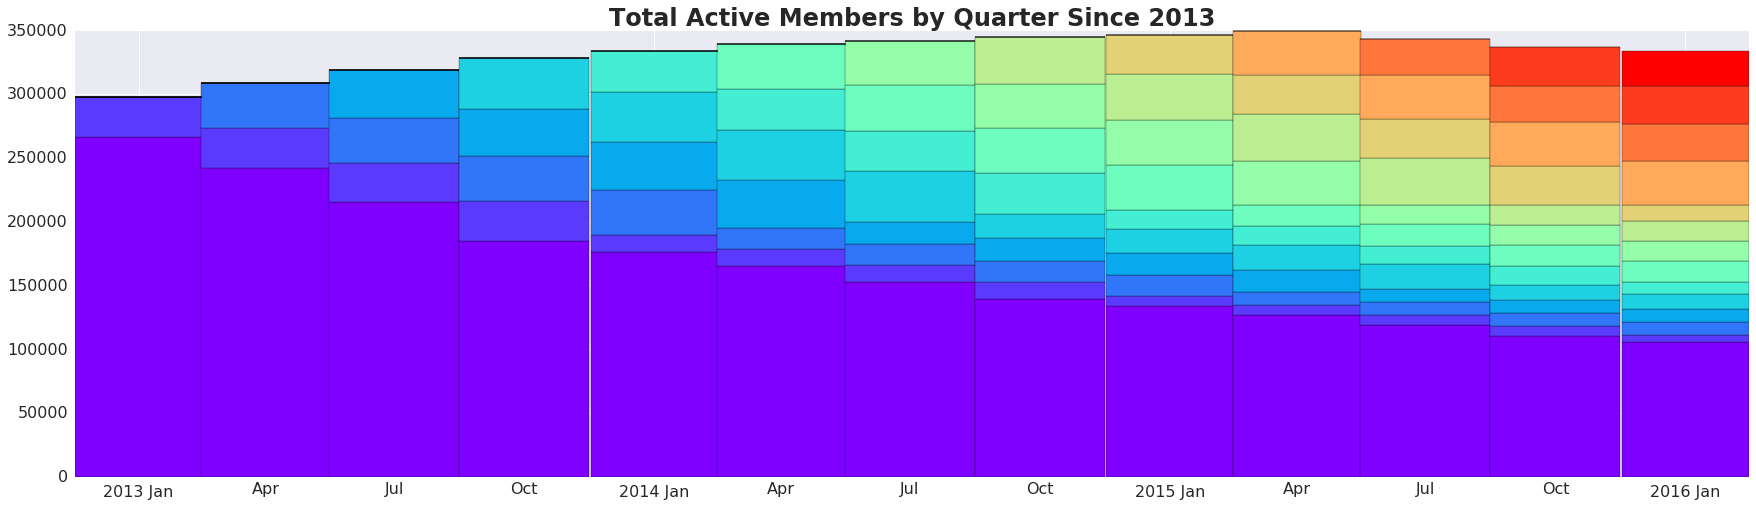

In [0]:
reload(tl)
tl.plot_cohorts(members, dt.datetime(2013, 1, 1), end=dt.datetime(2016, 4, 1),window=3, title='Total Active Members by Quarter Since 2013')

From thsi we can see that:
* in a quarter new members for that quarter are about 10% of the Total Active Members and New Members form about 40% of the Total Active Members. 
* the strong decline in new member sales is masked by the renewals.

Since sales volumes (inflow) declined starting April 2014 but renewals (leaks) have remained steady, total number of active members (i.e., water level) will slowly decline until a new equilibrium is acheived at some point in the future. This can be seen in the peak in active members April 2015 Quarter.

This same plot by month shows more detail and puts the active member peak at June 2015.  

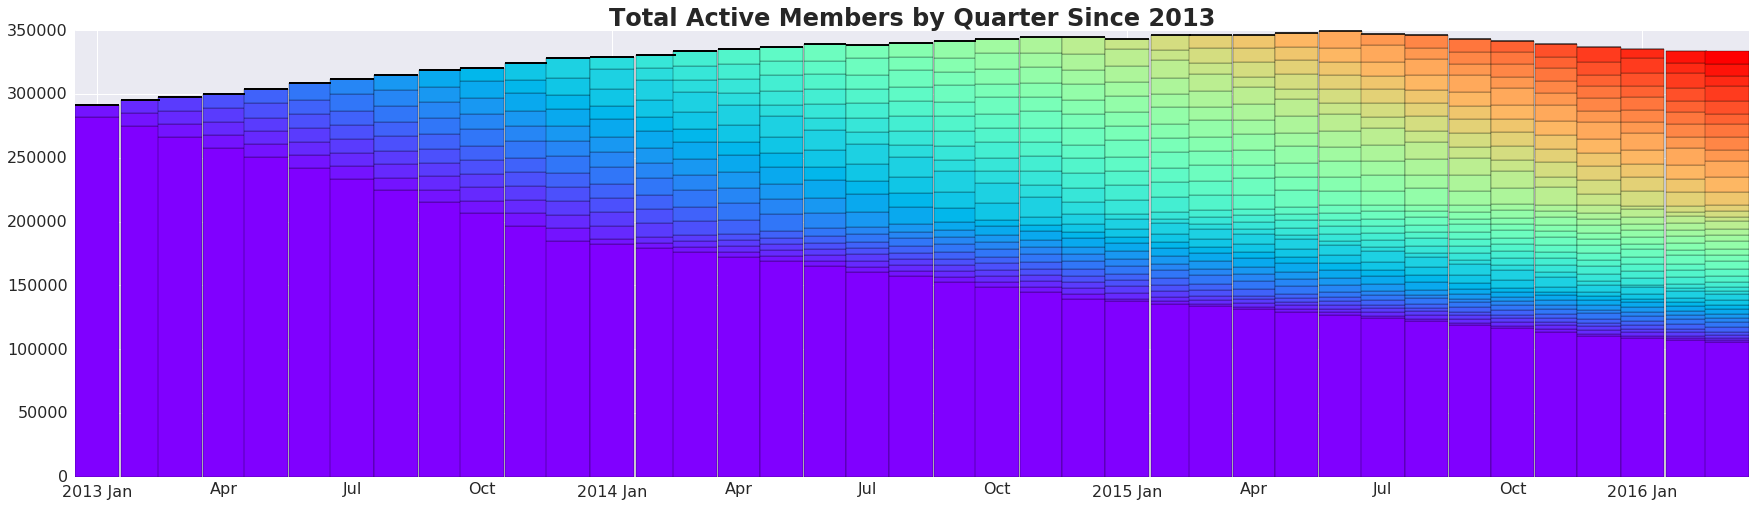

In [0]:
tl.plot_cohorts(members, dt.datetime(2013, 1, 1), end=dt.datetime(2016, 4, 1),window=1, title='Total Active Members by Quarter Since 2013')

**Bottom Line**: The decline in total active members appears to be largely driven by a reduction in new member sales rather than a drop in renewal rates. If sales volumes remain at the current lower rate the Total Memberships will continue to decline until it reaches the new steady state. 

The key questions to be considered are:
1. Have sales volume stopped falling or are they still in decline?
2. Why did sales volumes fall?
3. What is the new steady state level of total active members?

# Segmentation by Country

## New Member Sales

The chart below break out the 7 countries with the largest sales and lumps the reminder in "Other".

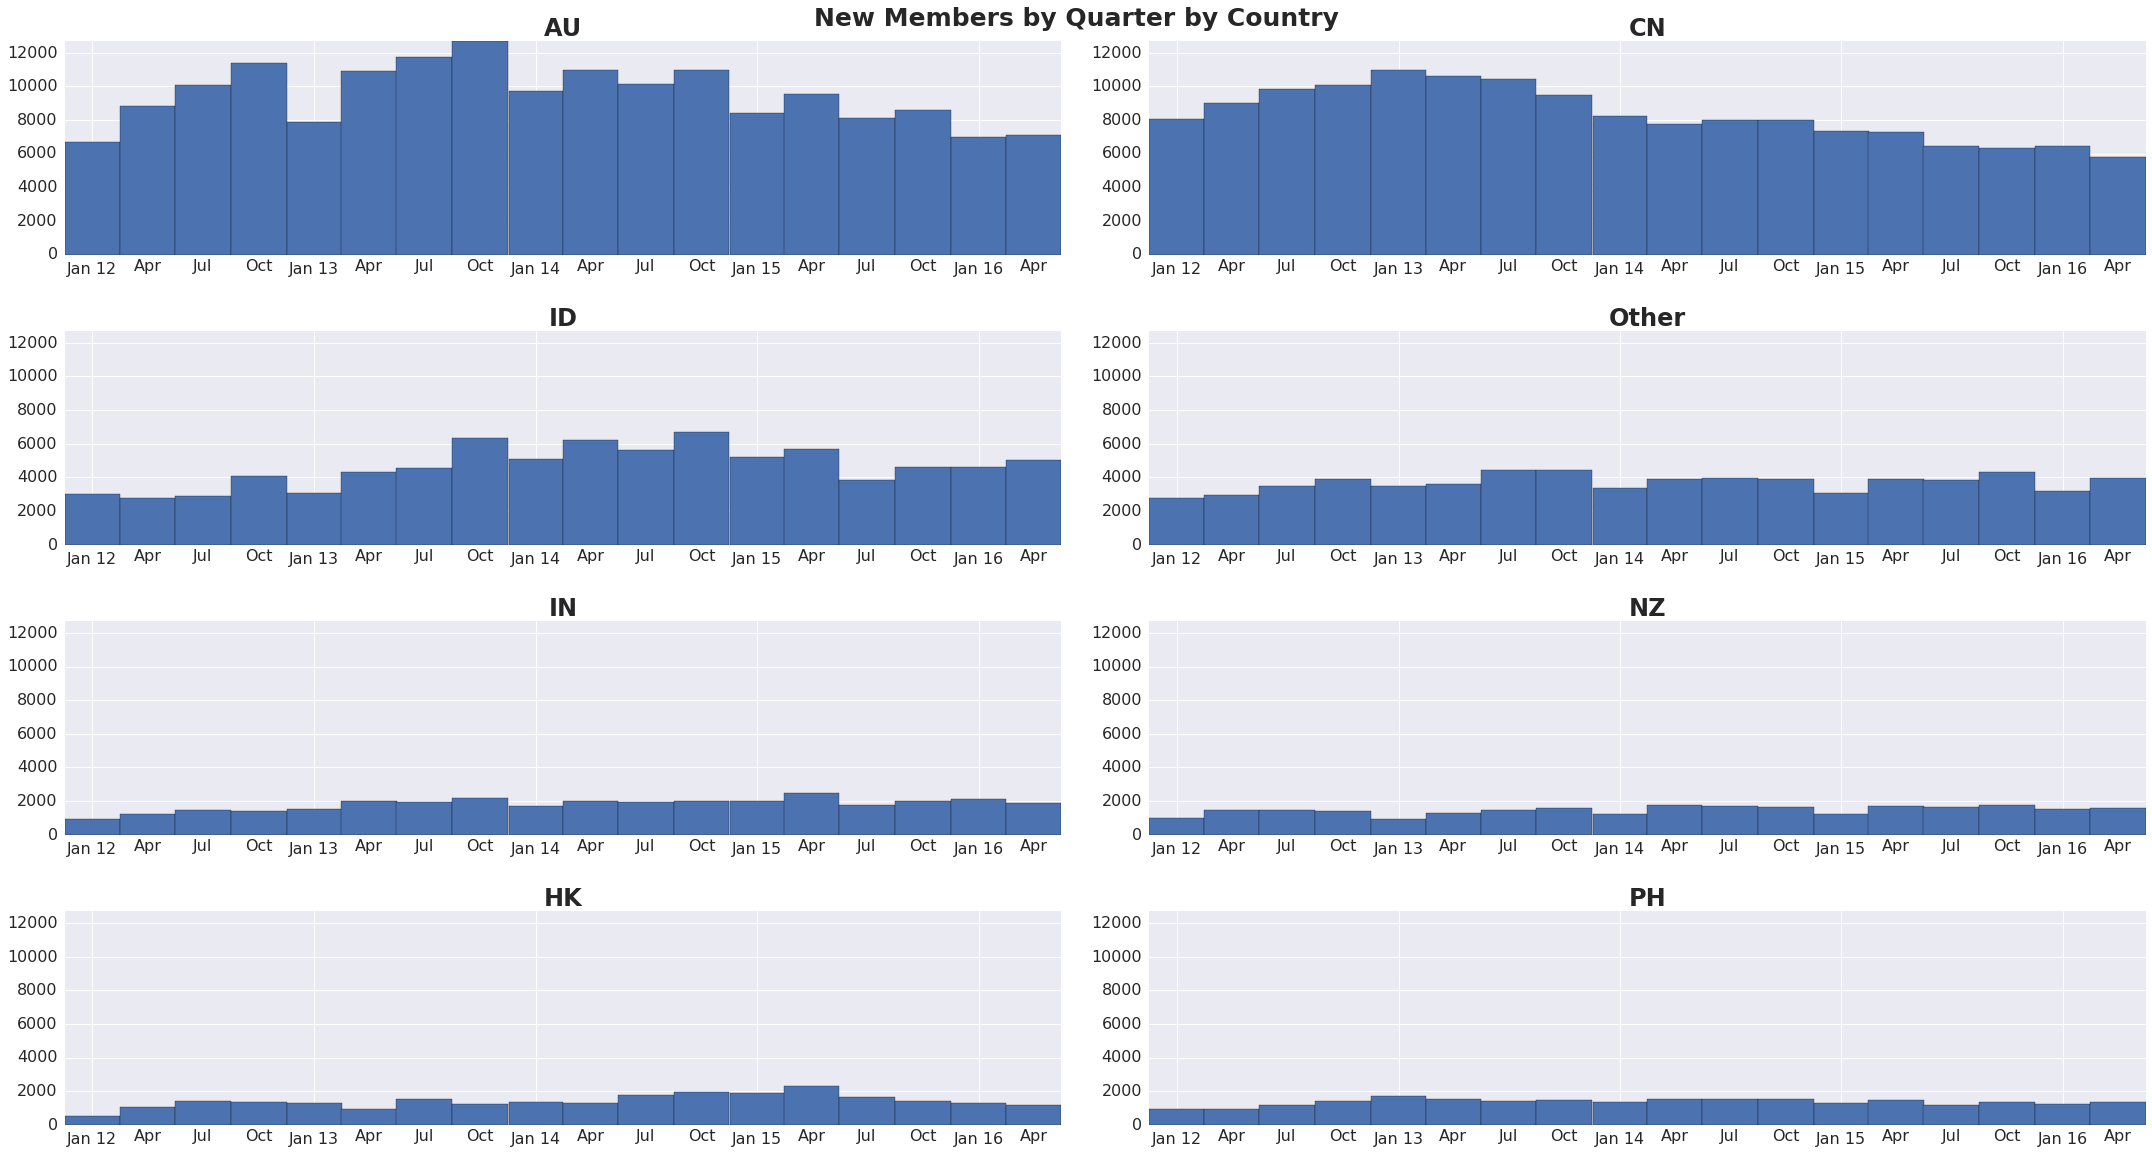

In [0]:
tl.plot_new_sales_by_segment(members, dt.datetime(2012, 1, 1), 'Country', k=7)

**Australia**
* sales had a strong ramp up in 2012 and 2013. Is this an artifact or real?
* Since Jan 2014 year over year quarterly sales have been in decline. Why?
* In most years April is stronger than Jan, however in 2016 this is not true but is probably due to the data being extracted as of 14th of July?

**China**
* Also ramped up strongly from Jan 2012 to Jan 2013, then goes in to decline. Why?
* A further slump in the second half of 2015, but slower than in 2015

Looking at the total new members, with Australia and China shown seperately confirms the decline largely due to these two countries.

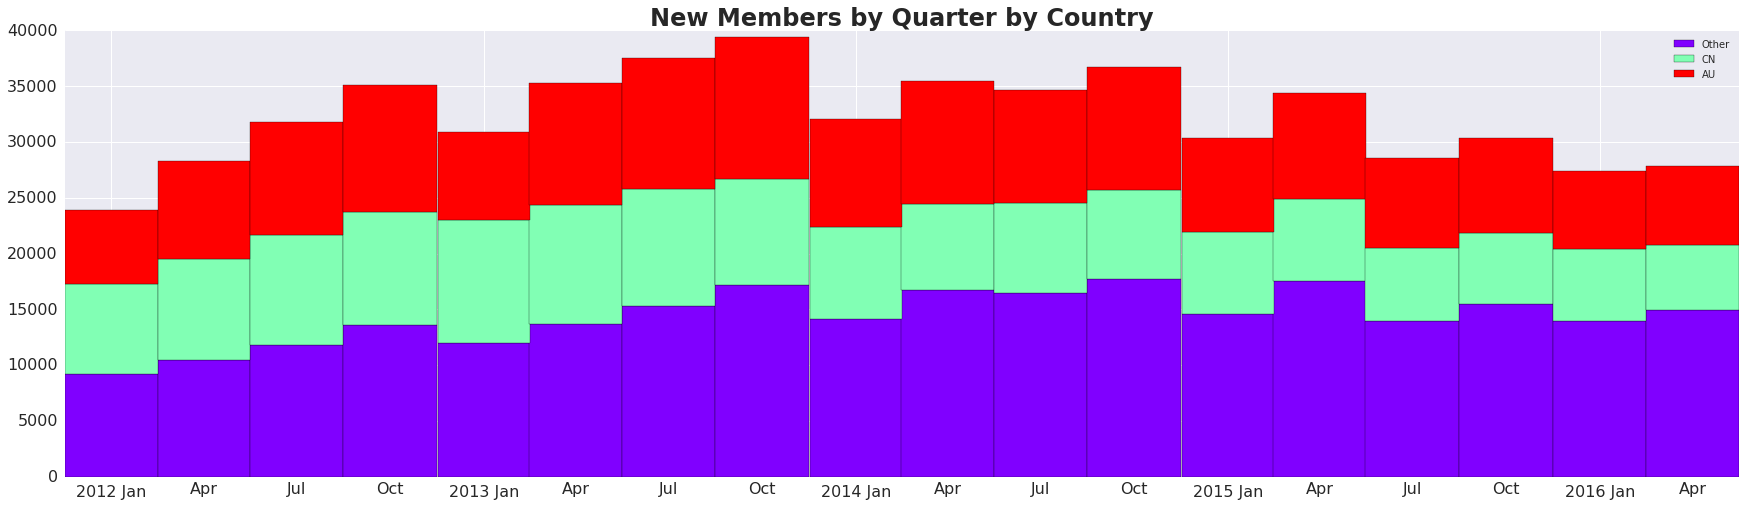

In [0]:
table = tl.new_sales(members, dt.datetime(2012, 1, 1),window=3, segment='Country', k = 2)
matrix = tl.to_matrix(table, column='Segment' ).swap_columns('AU', 'Other')
tl.plot_bar_stacked(matrix, title='New Members by Quarter by Country', legend=True)

**Question:** What drove the ramp up from Jan 2012 to Oct 2013 in China and Australia. What drove the decline?
* Where there changes across the bueinss?
* Did sales plans or sales staffing or sales models change?
* Did the membership plans change?
* Was there a change in envionmental factors?

## Churn

We segment the data by Country and show Churn for 1 year cohorts. 

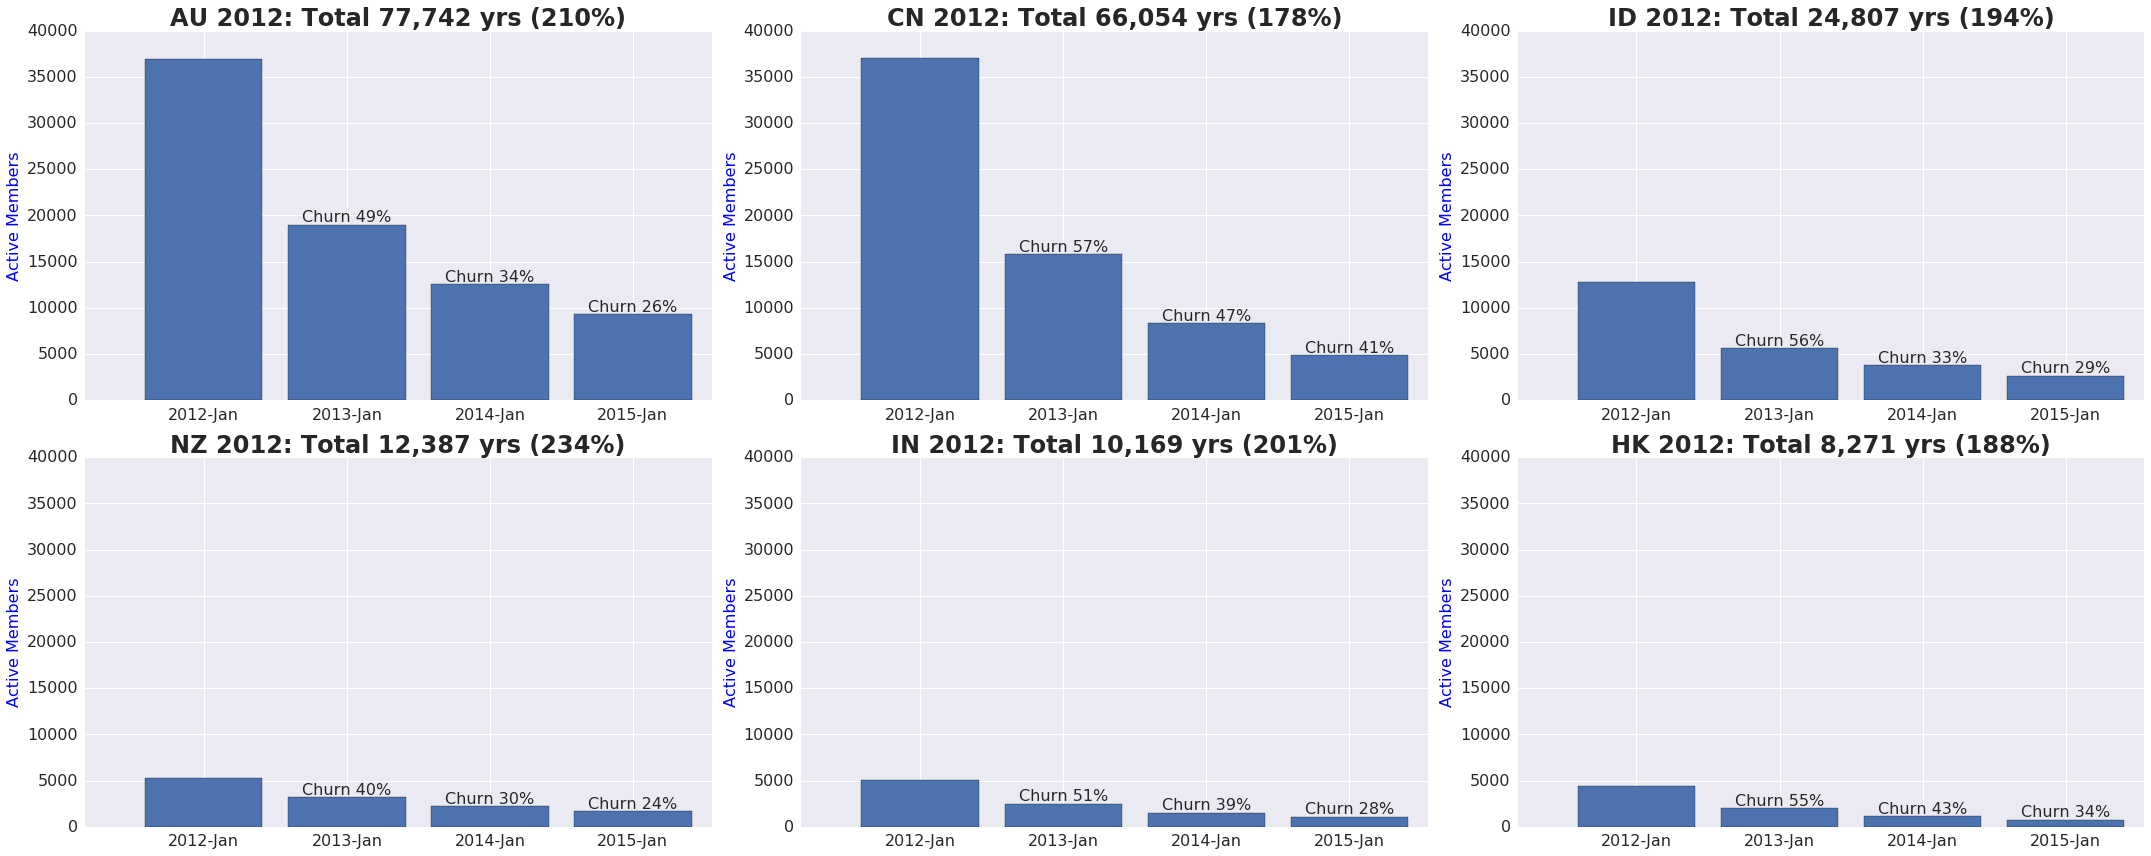

In [0]:
year = 2012
countries = ['AU', 'CN', 'ID','NZ',  'IN', 'HK' ]
fig, axes = plt.subplots( 2, 3, figsize=(30,12))
for ax, country in zip(axes.flatten(), countries):
    segment= members[(members['Country'] == country)]
    start =dt.datetime(year, 1, 1)
    r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',start , window=12)    
    tl.plot_retention(r, "{} {:%Y}".format(country, start), ax)
    ax.set_ylim(0,40000)
plt.tight_layout()

This shows that 
* NZ has the lowest first year churn rate of 40% and over all best retention. Why?
* Australia is second with 49% and India with 51%.
* India has surprisingly good retention, similar to Australia. Why?
* China has the worst first year churn of 57% and poor over all retention.
* The second and subsequent year churn rates are significantly worse in China than other countries.

To put this in perspective, while 
* Australia and China have similar sales, by the end of the 3rd year Australia retains 2x the number of members that China does.
* China has nearly 3x the sales of india, by the end of the 3rd year China only retains 2x as many members. 

Areas for consideration are:
* Invest more heavily in India due to strong retention?
* Understand why NZ has such strong retention. What do they do differently than Australia?
* Investigate why China has such poor first and subsequent year retentions.

The plots below of the retention for the cohorts 2012, 2013, and 2014 for  Australia and China

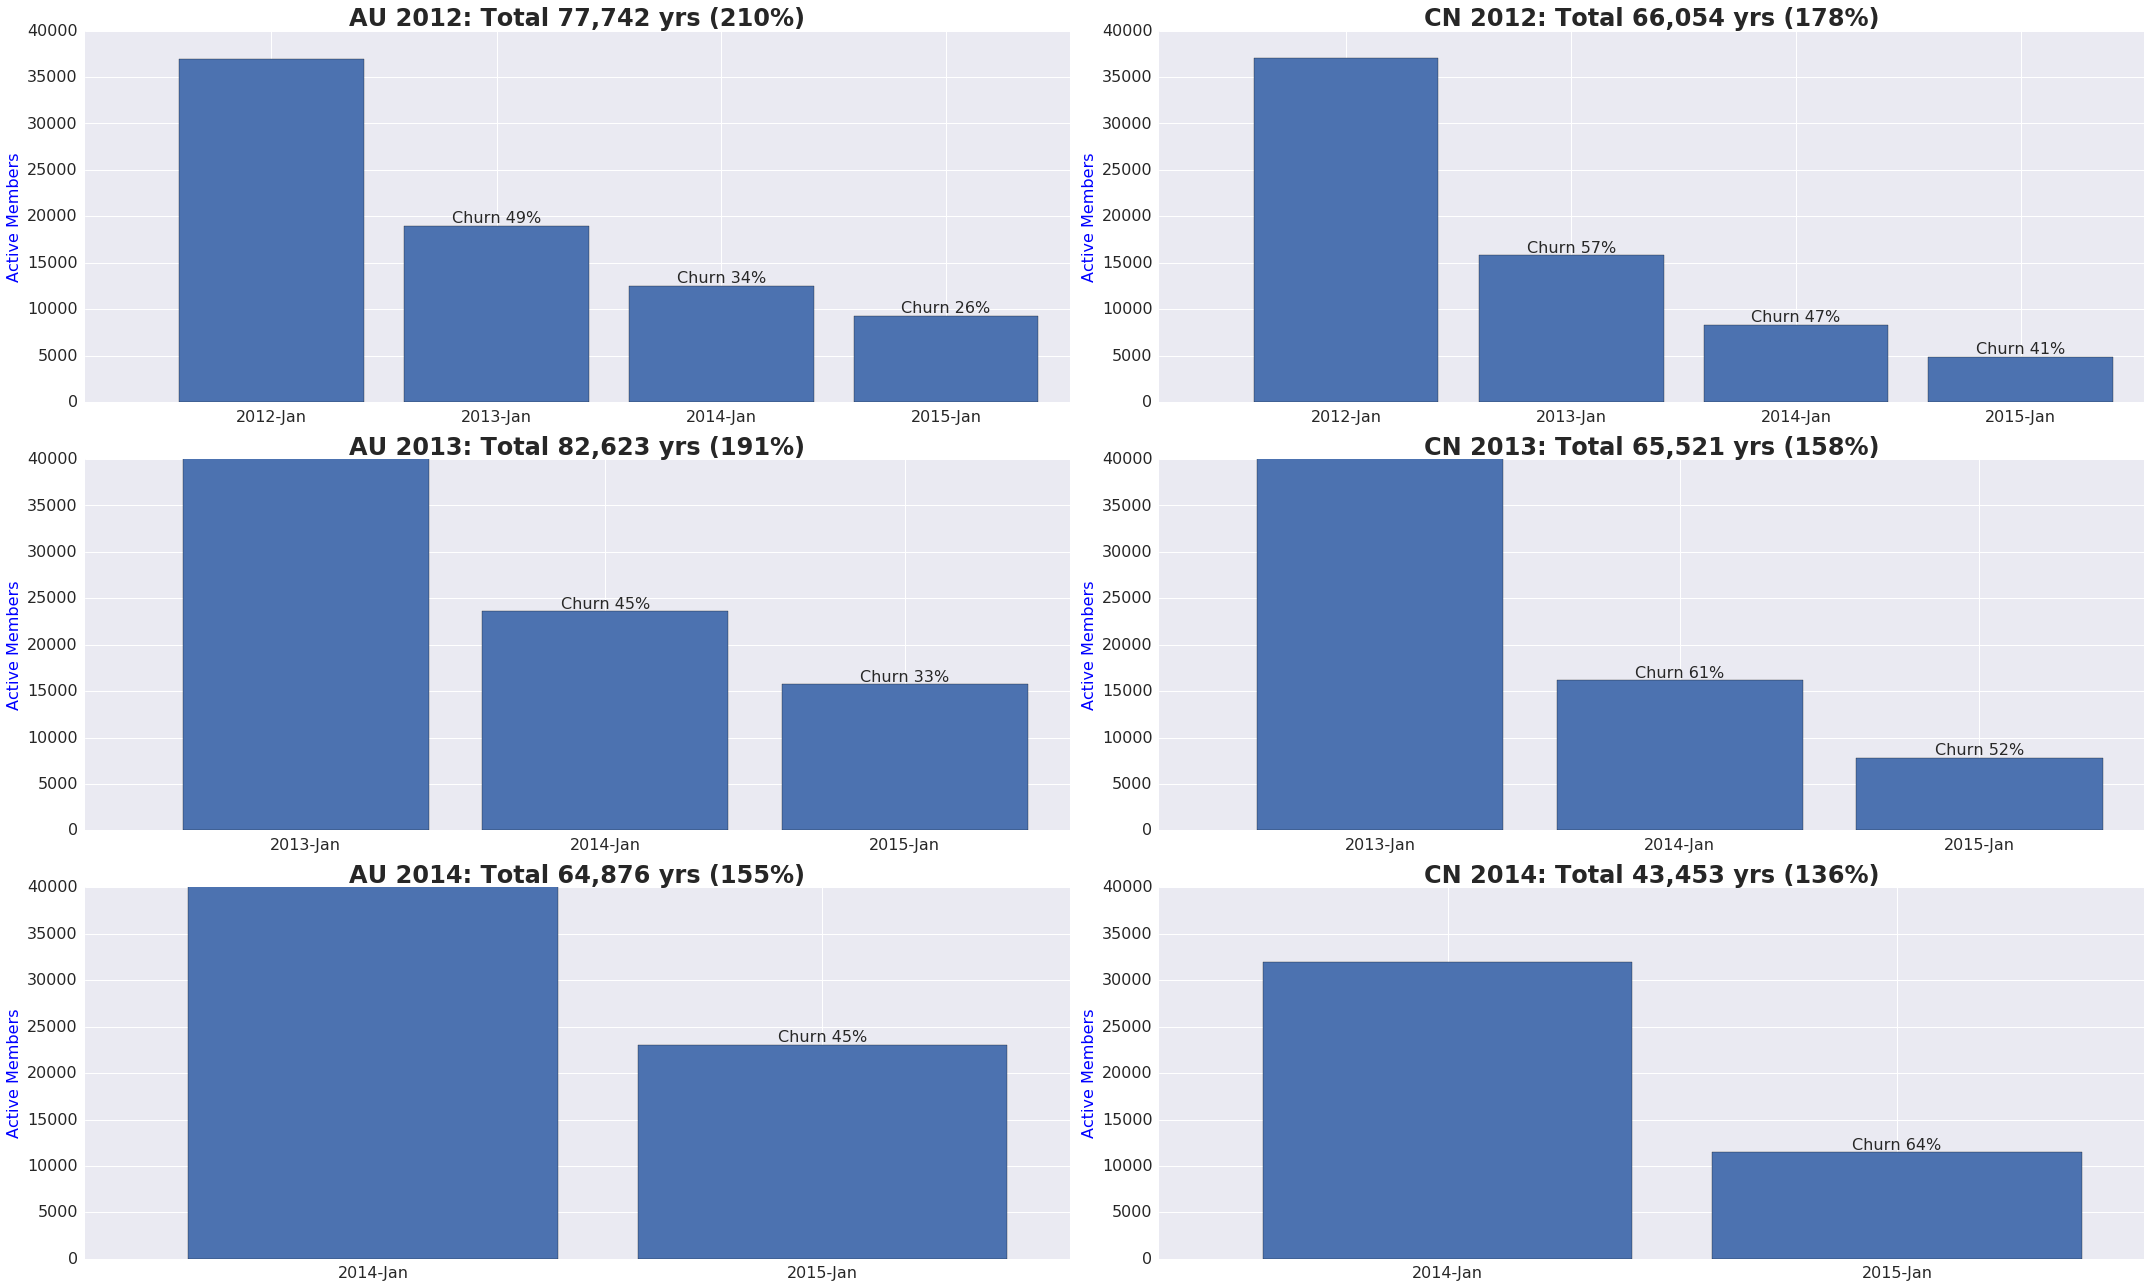

In [0]:
years = [2012, 2013, 2014]
countries = ['AU', 'CN' ]
fig, grid = plt.subplots(len(years),  len(countries), figsize=(30,6*len(years)))
for  year, axes in zip(years, grid):
    for country, ax  in zip(countries, axes):
        segment= members[(members['Country'] == country)]
        start =dt.datetime(year, 1, 1)
        r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',start , window=12)    
        tl.plot_retention(r, "{} {:%Y}".format(country, start), ax)
        ax.set_ylim(0,40000)
plt.tight_layout()

From these, it appears that the Australian Churn rates are roughtly stable over these years, however there are weak indications that China retention has gotten worse.

# Department view

## Australia

**Question:** What do you see in these plots about the decline in sales?

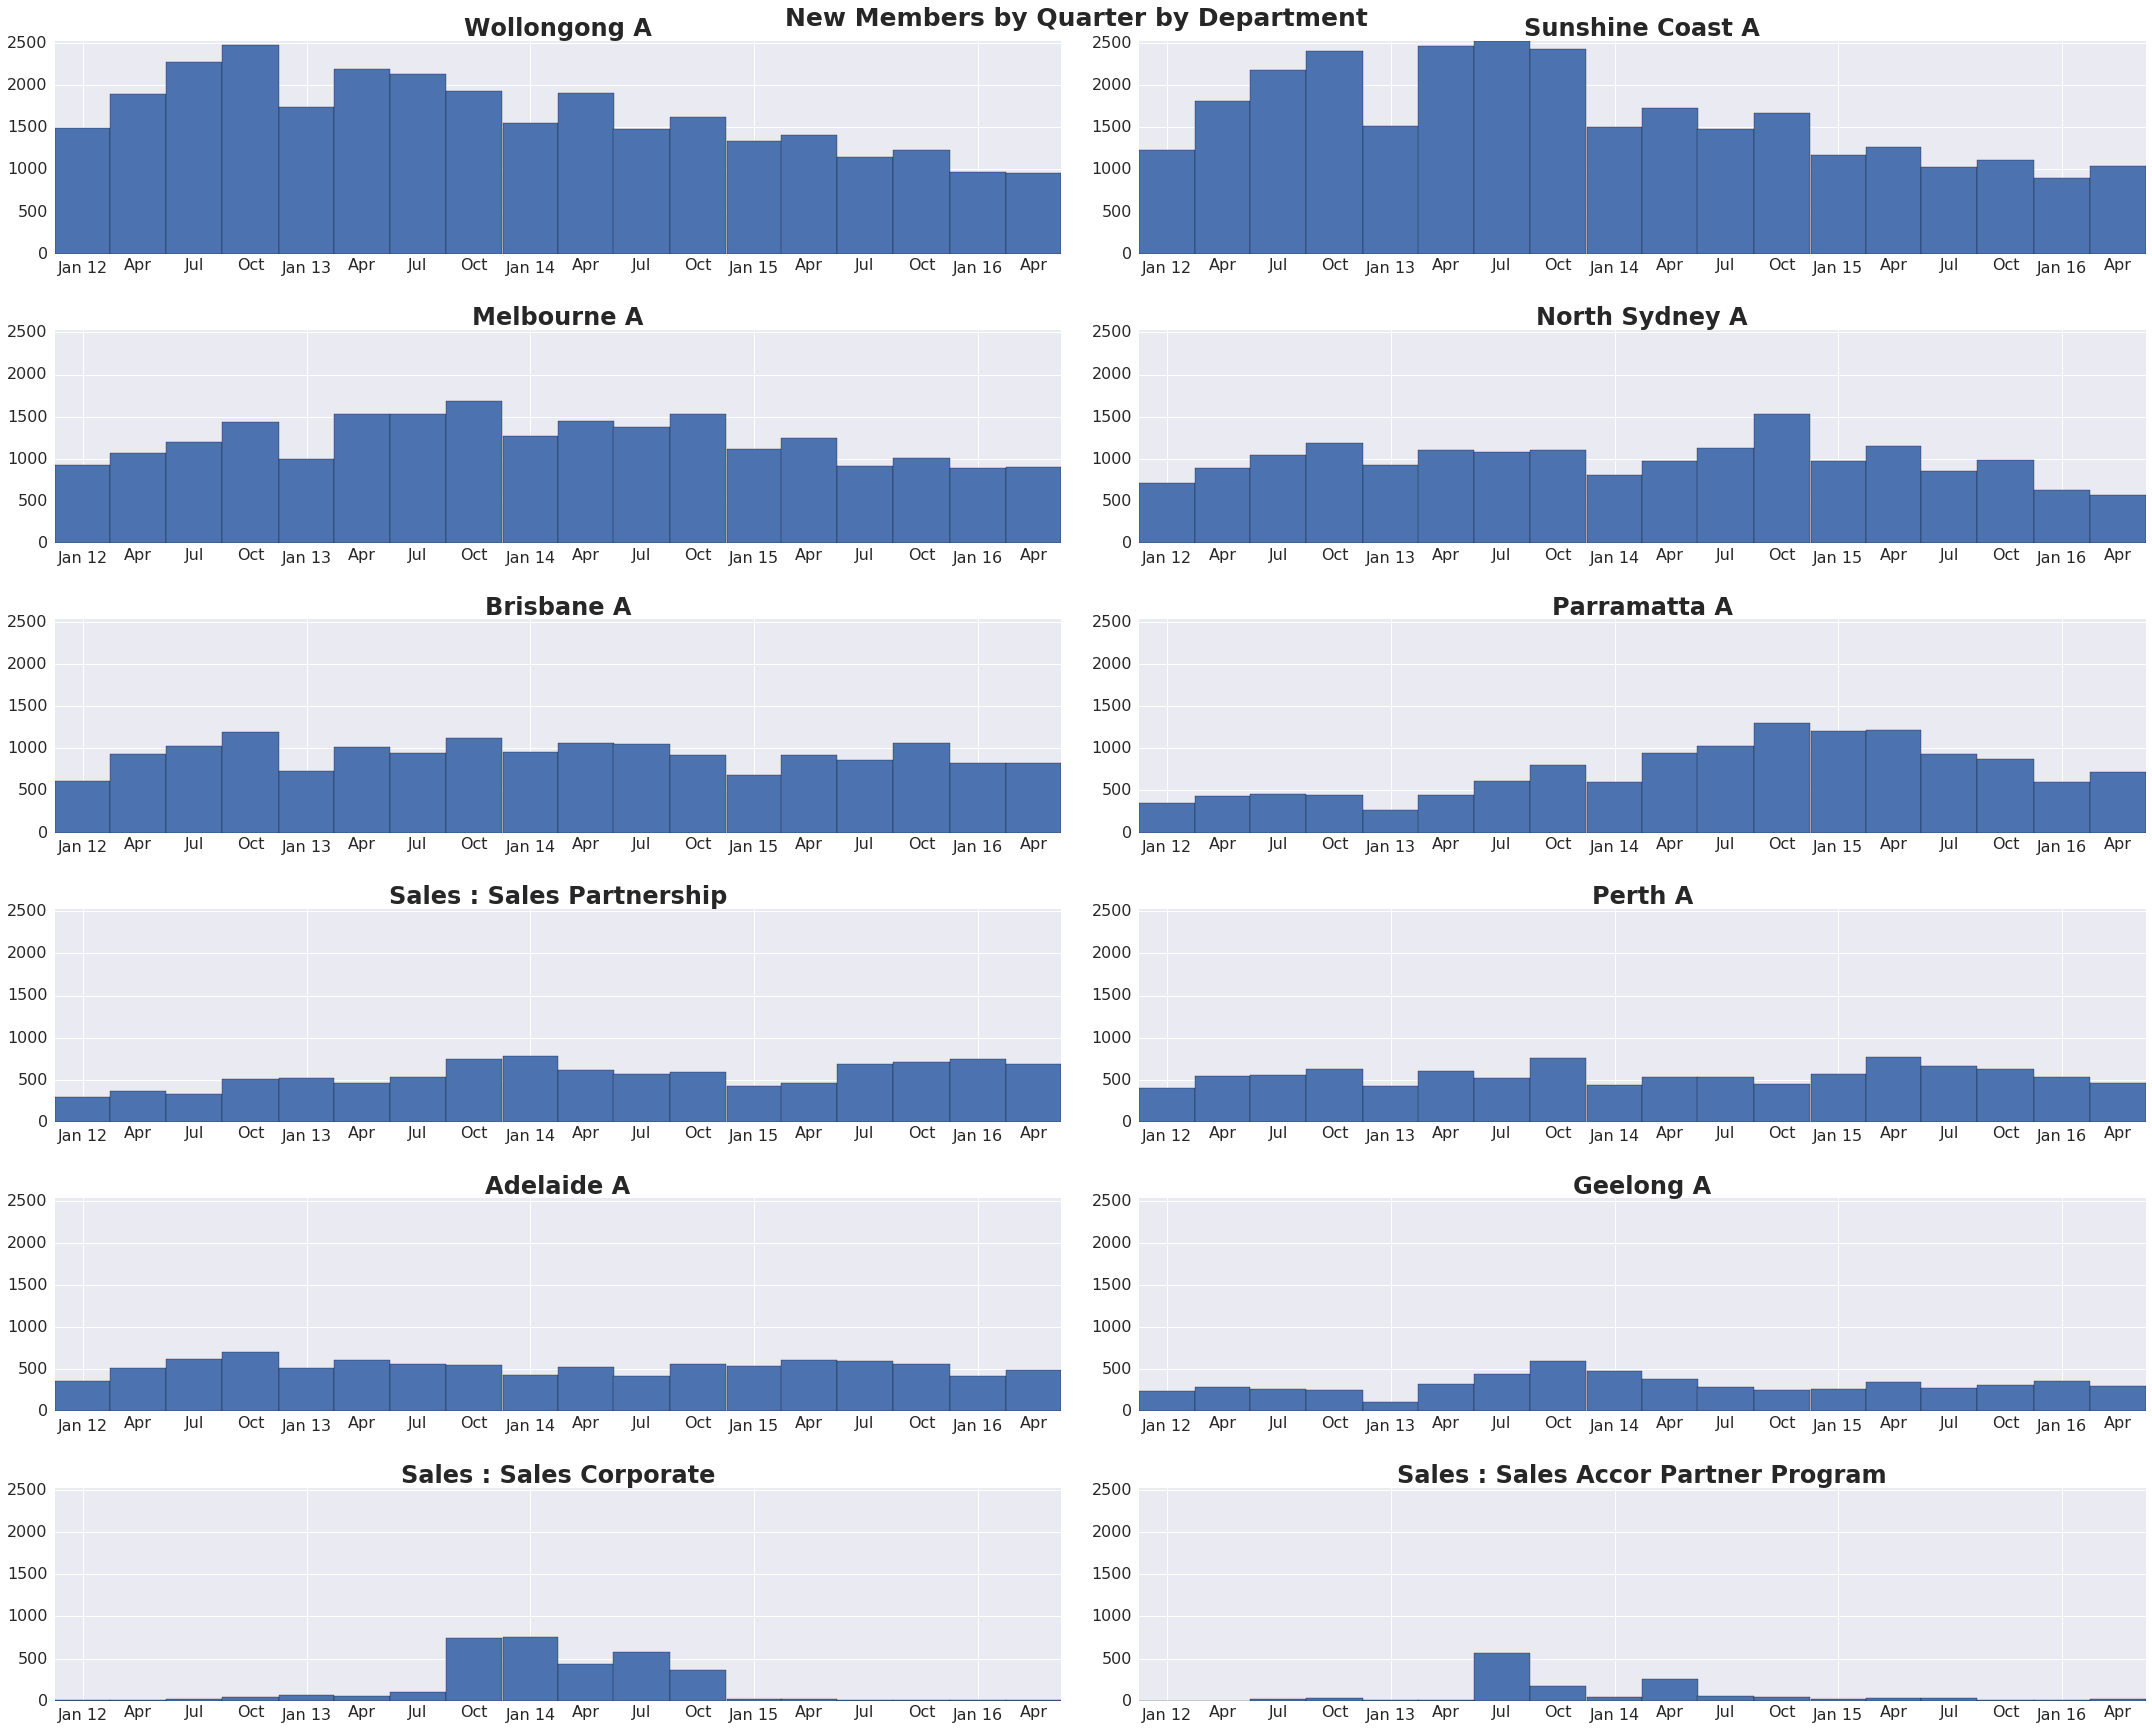

In [0]:
AU_members = members[members['Country'] == 'AU']
tl.plot_new_sales_by_segment(AU_members, dt.datetime(2012, 1, 1), 'Department',  k=12, drop=['Other'])

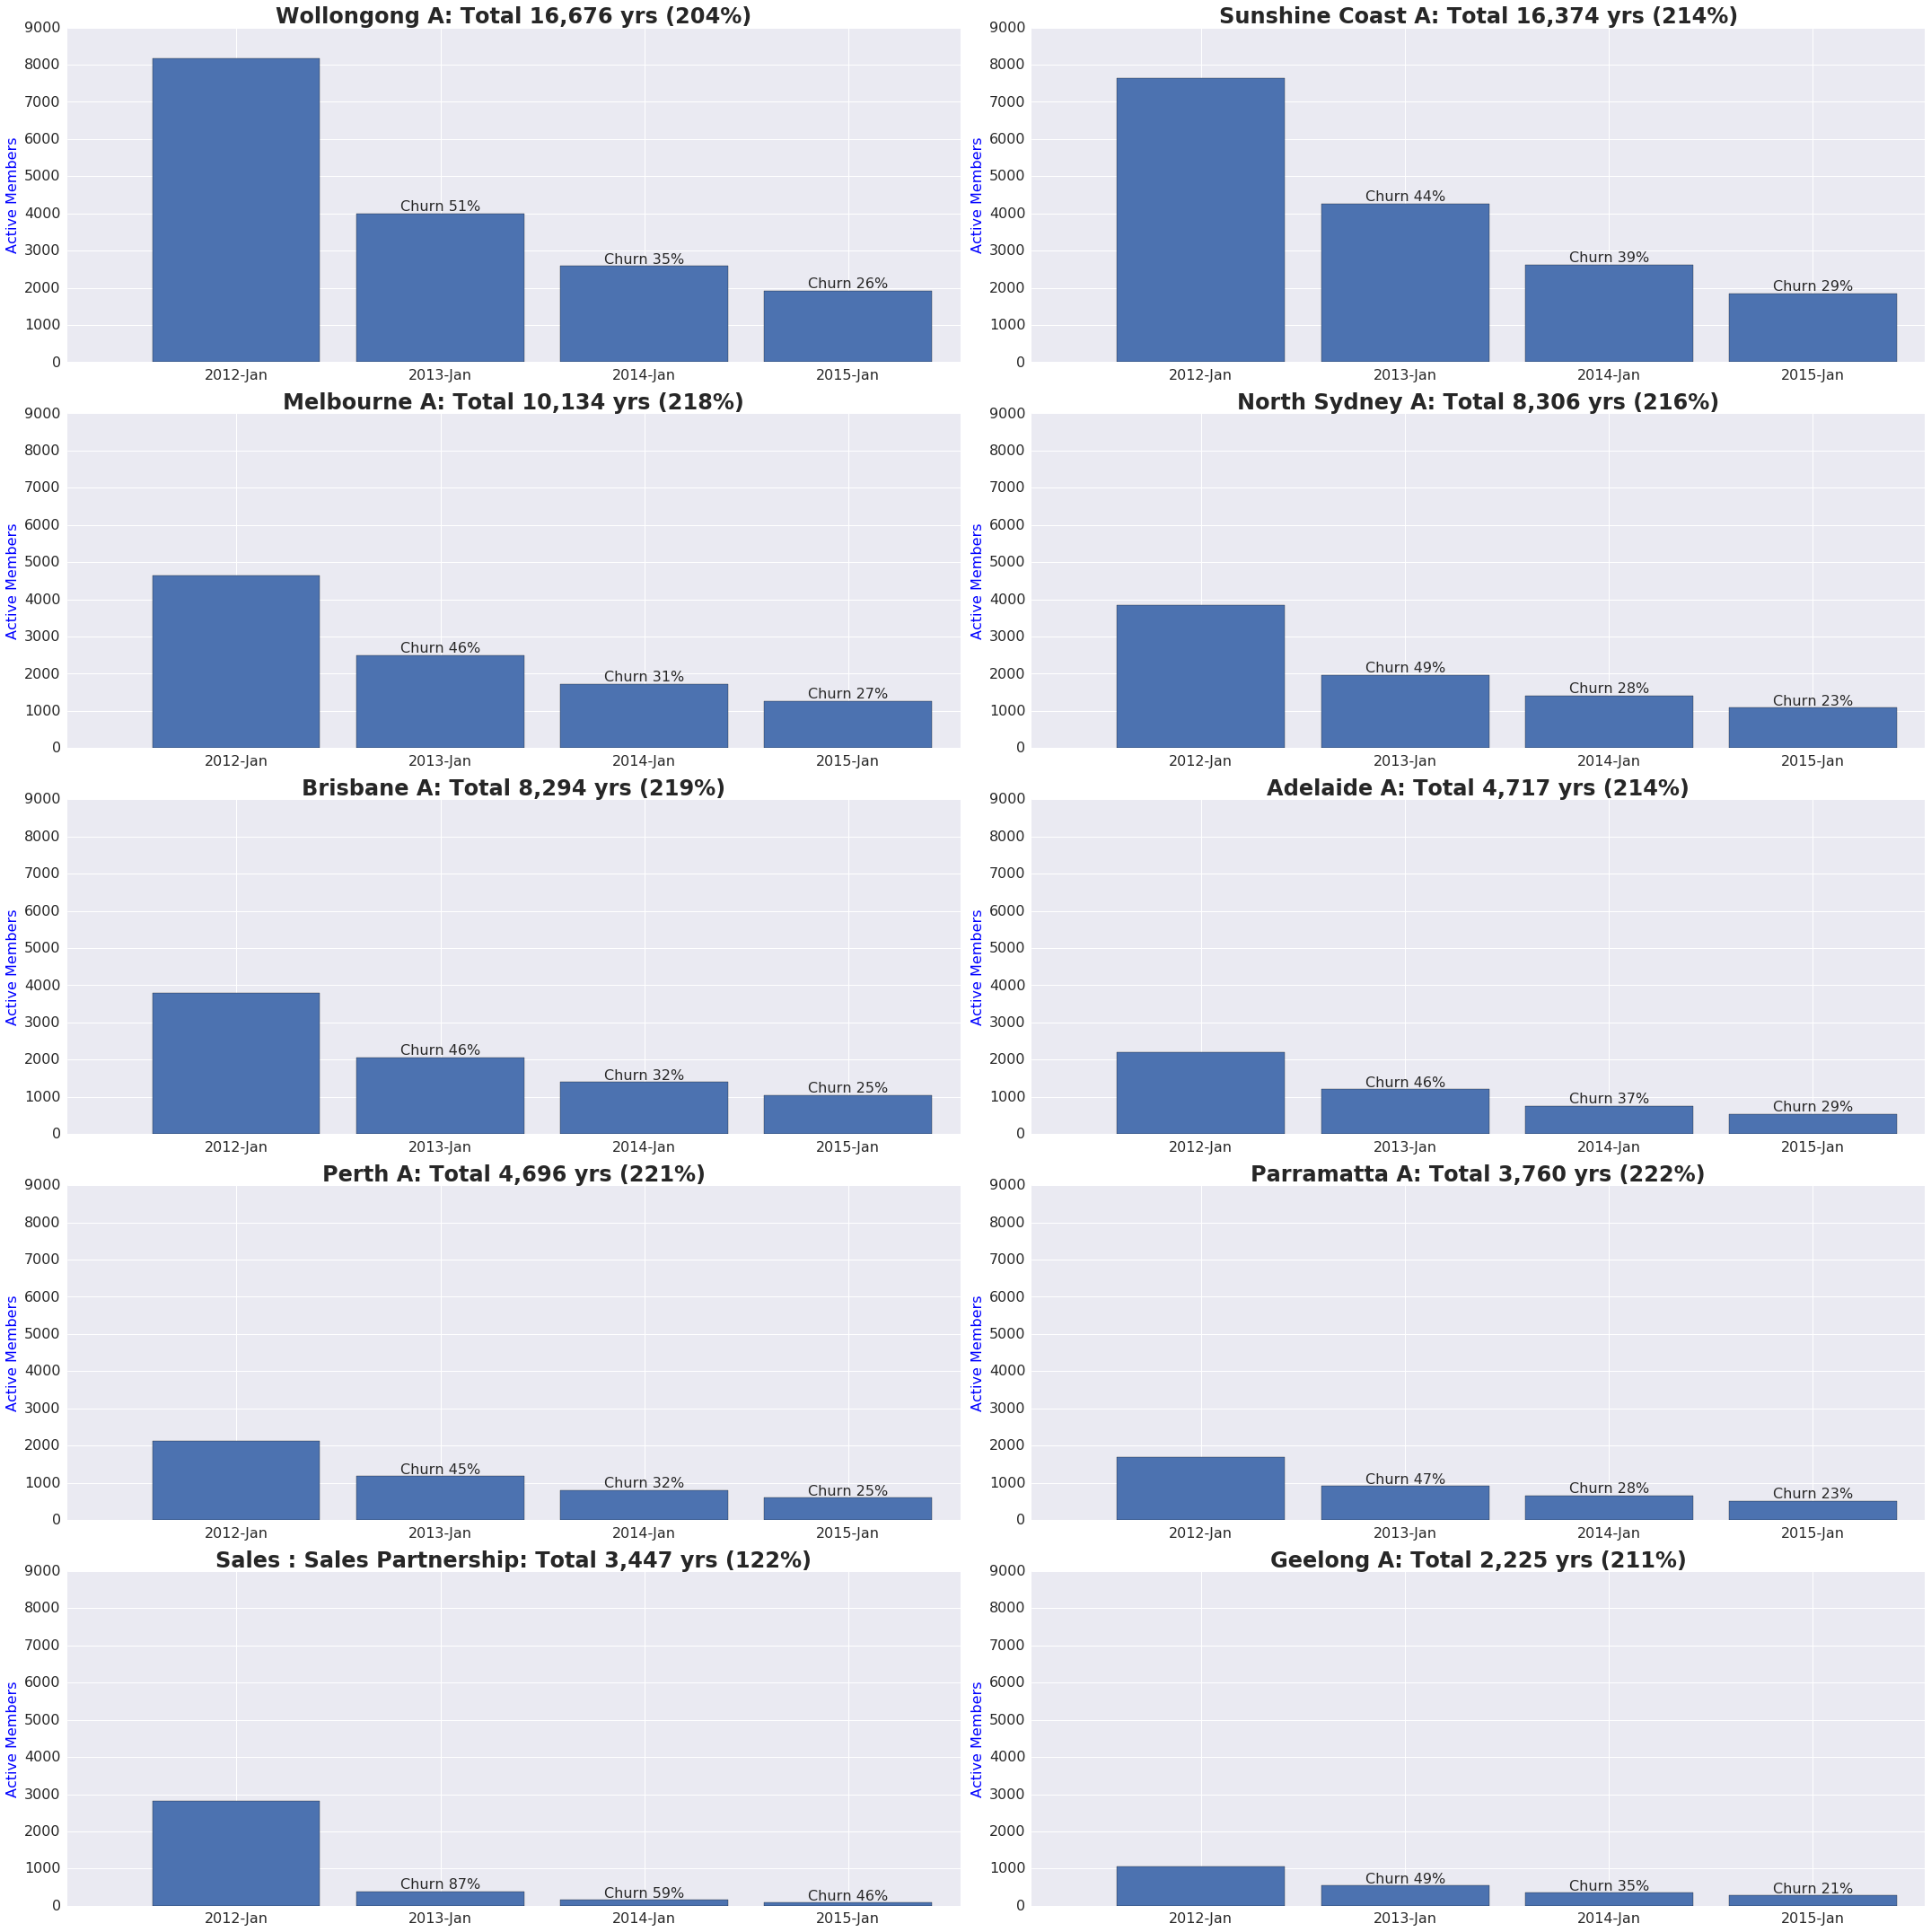

In [0]:
AU_members = members[members['Country'] == 'AU']
fig, axes = plt.subplots(5,2, figsize=(30,6*5))
year=2012
start =dt.datetime(year, 1, 1)
departments = tl.cohort(AU_members, 'MEMBER_SINCE',start, window=12).groupby('Department', gl.aggregate.COUNT).sort('Count', ascending=False)
departments = departments.topk('Count', k=10)

for ax, department in zip(axes.flat, departments['Department']):
        segment= members[(members['Department'] == department)]

        r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',dt.datetime(2012, 1, 1) , window=12)    
        tl.plot_retention(r, "{}".format(department), ax)
        ax.set_ylim(0, 9000)
plt.tight_layout()

## China

**Question:** What do you see in these plots about the decline in sales?

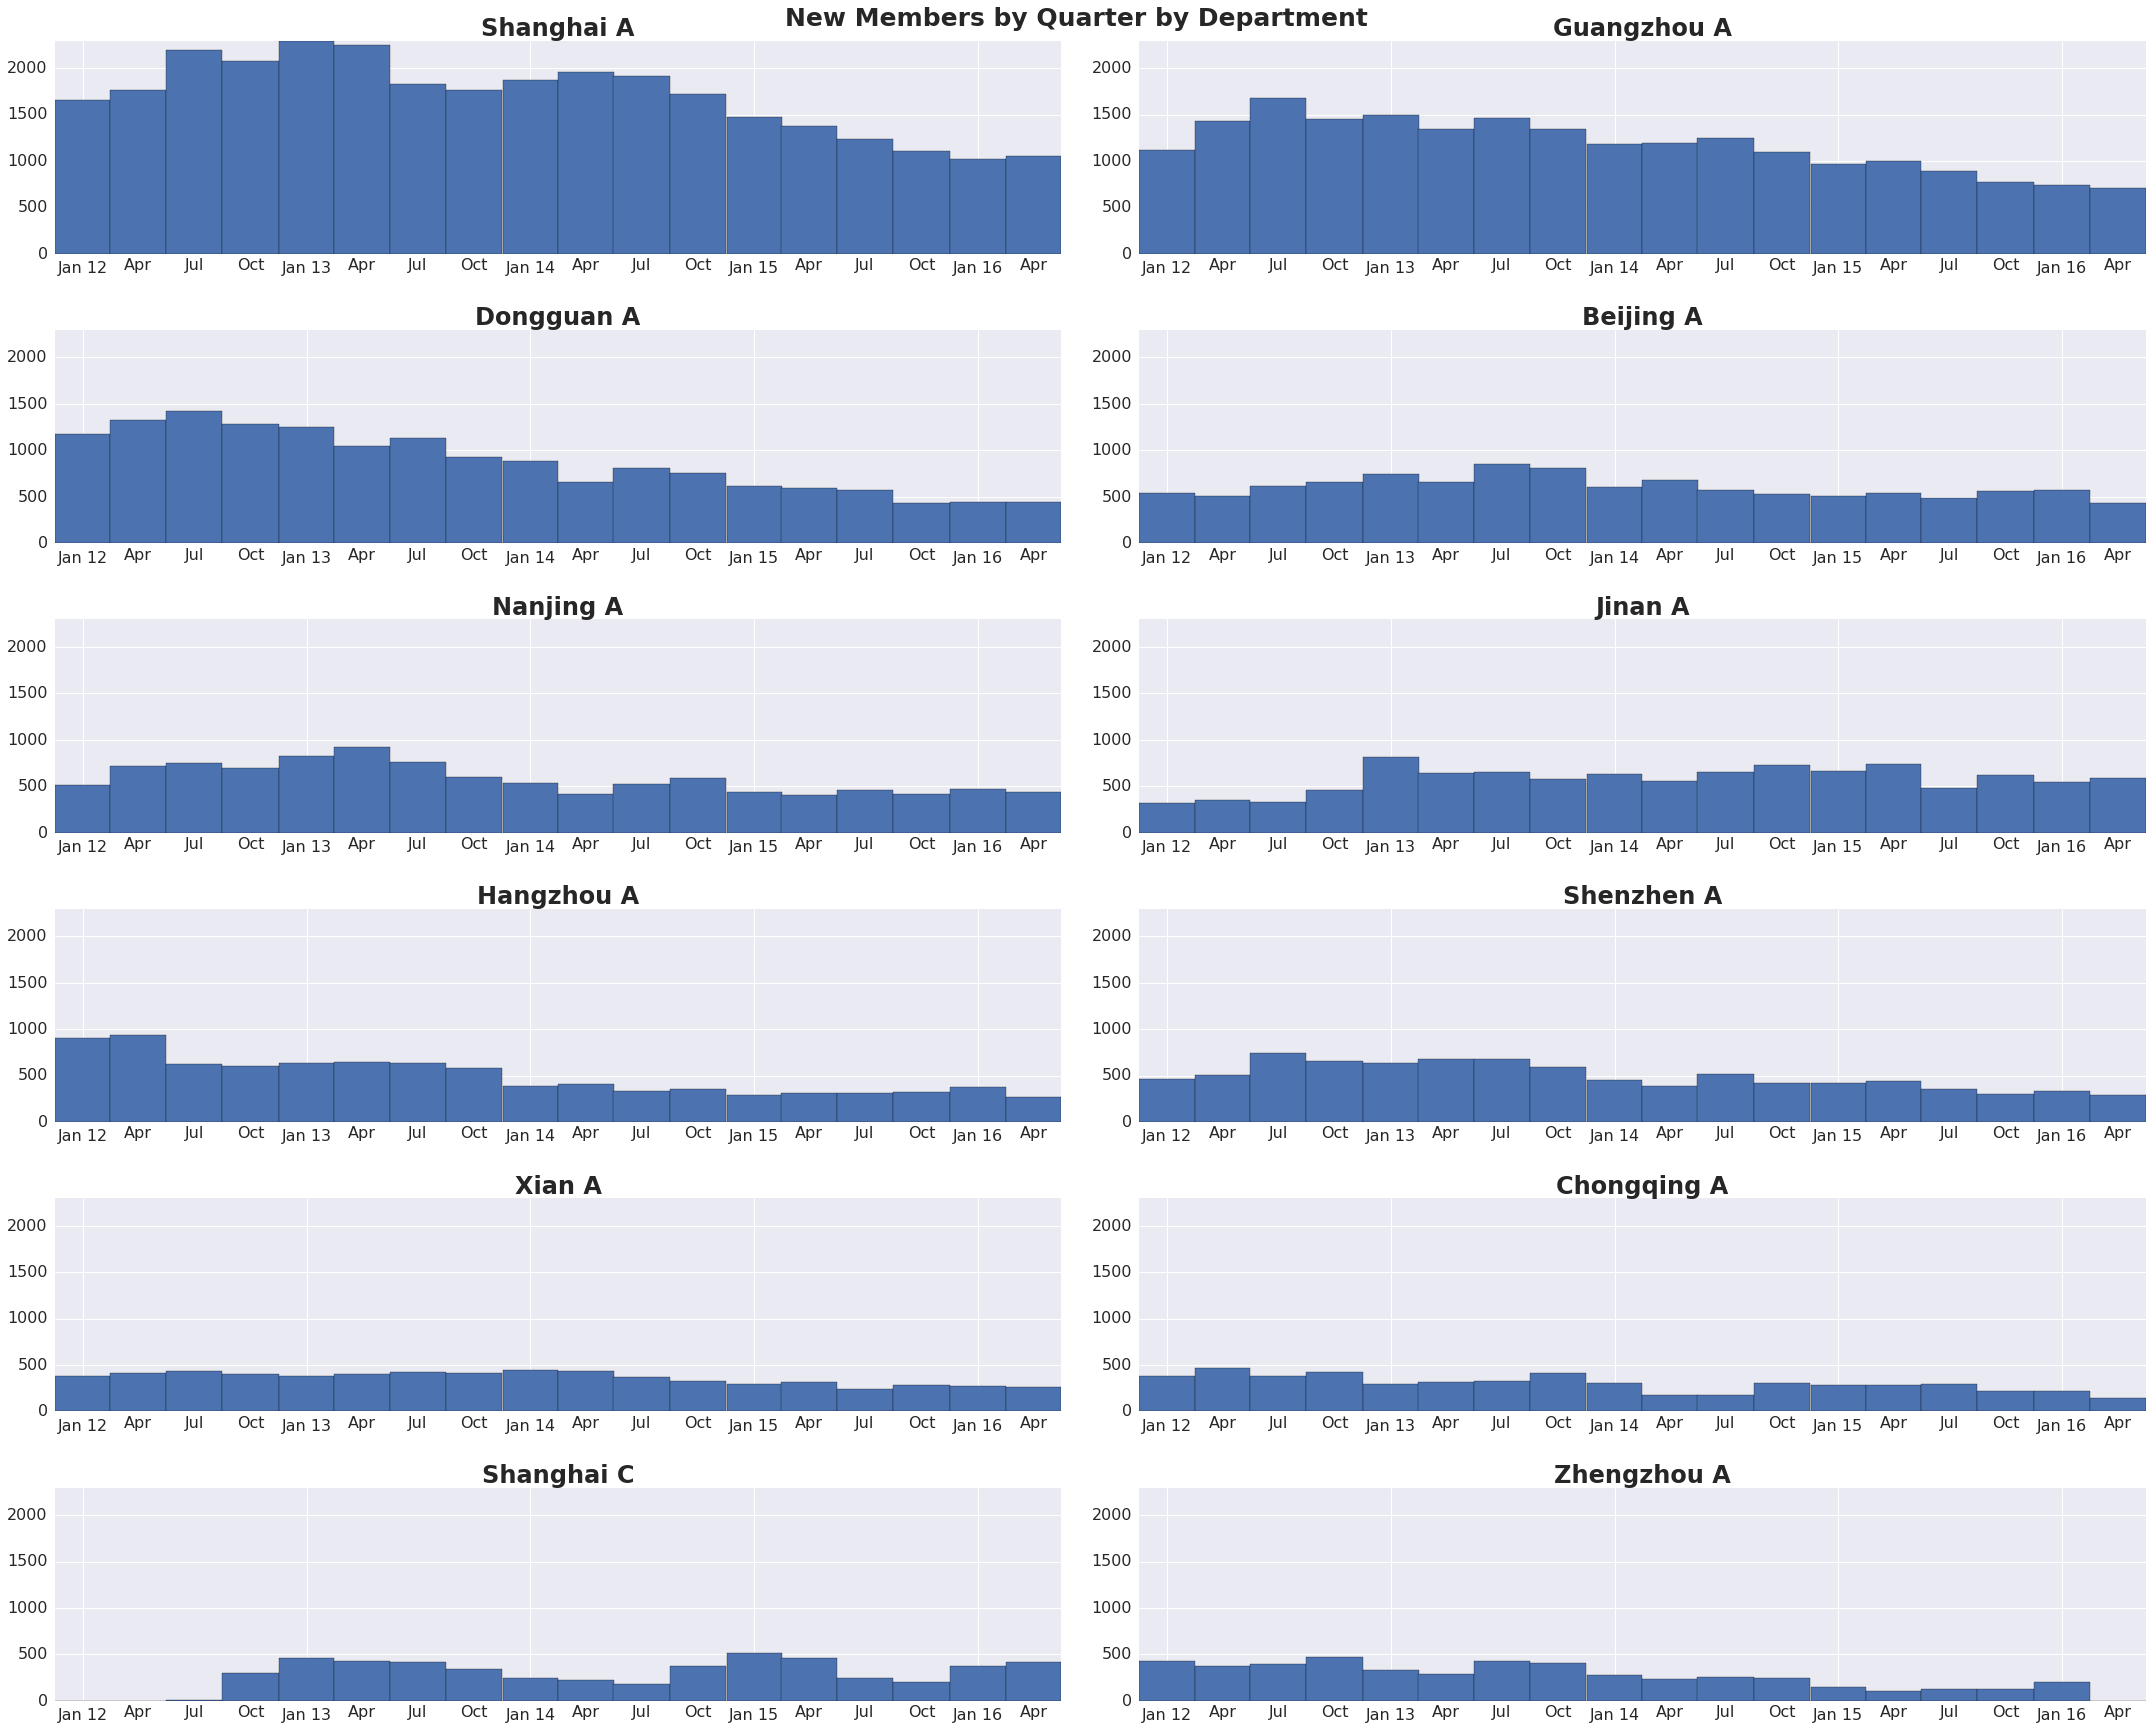

In [0]:
CN_members = members[members['Country'] == 'CN']
tl.plot_new_sales_by_segment(CN_members, dt.datetime(2012, 1, 1), 'Department', k=12, drop=['Other'])

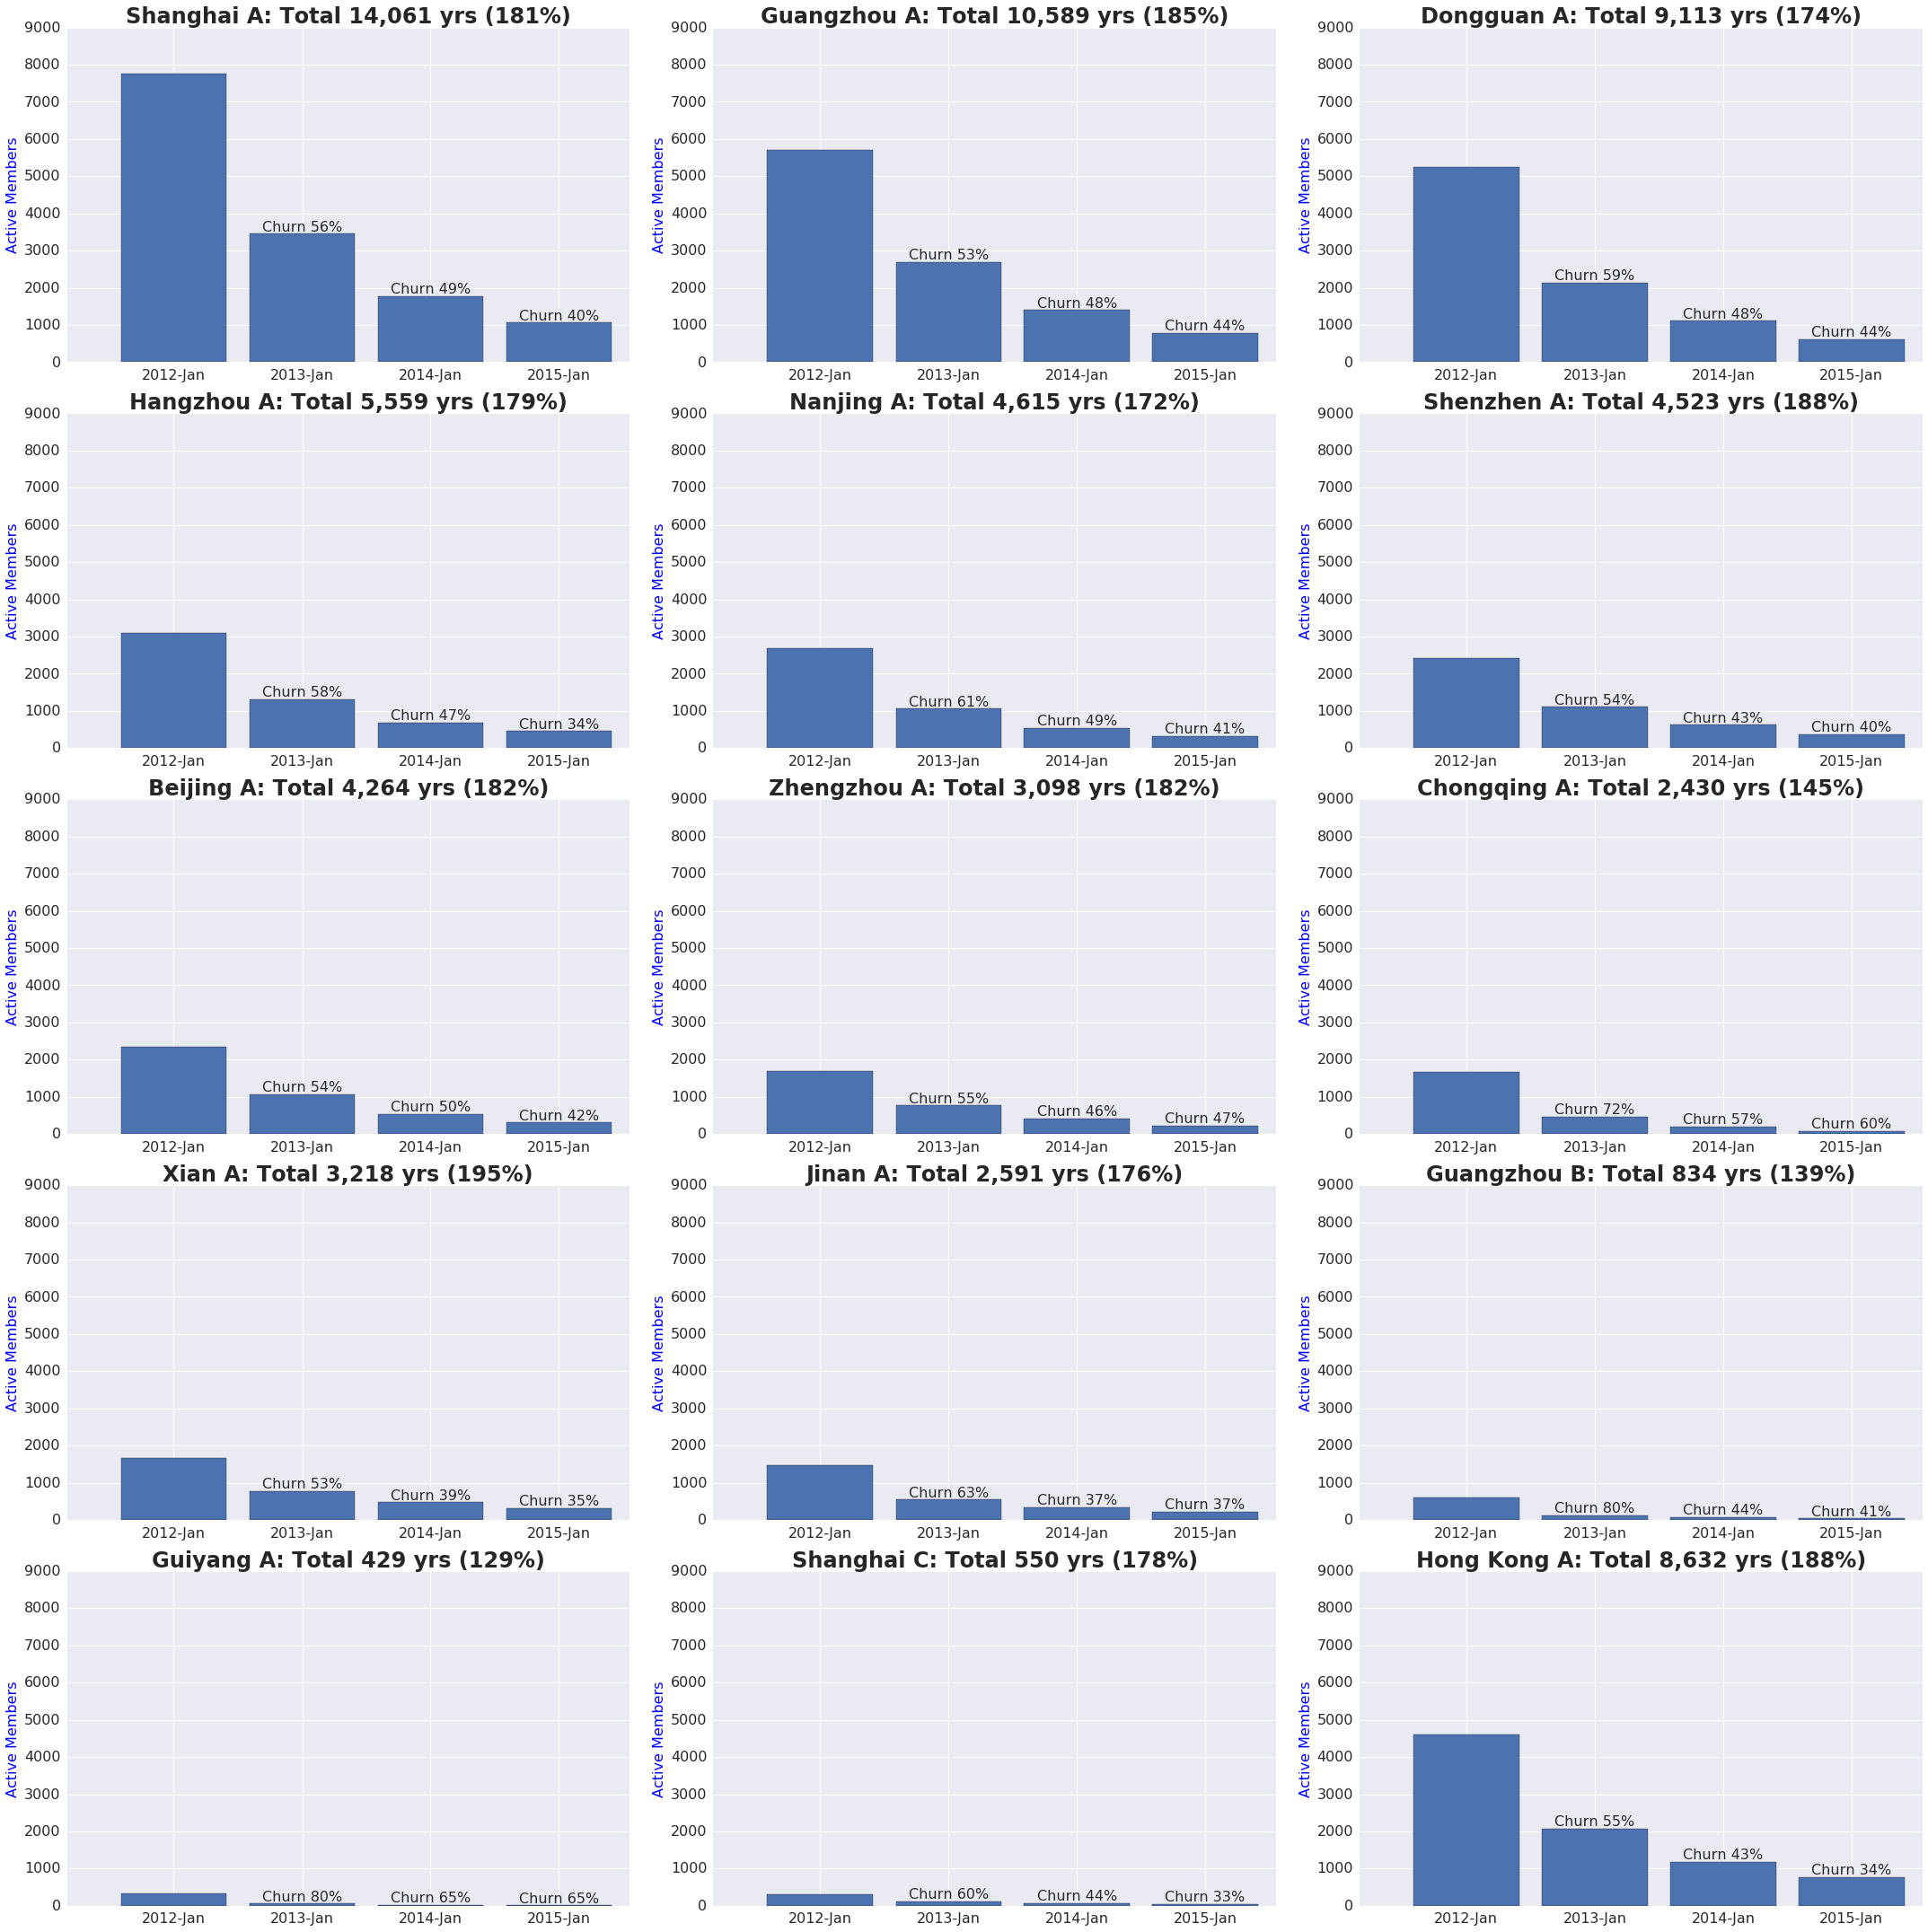

In [0]:
segment = members[members['Country'] == 'CN']
fig, axes = plt.subplots(5,3, figsize=(30,6*5))
year=2012
start =dt.datetime(year, 1, 1)
departments = tl.cohort(segment, 'MEMBER_SINCE',start, window=12).groupby('Department', gl.aggregate.COUNT).sort('Count', ascending=False)
departments = departments.topk('Count', k=21)

for ax, department in zip(axes.flat, departments['Department']):
        segment= members[(members['Department'] == department)]

        r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',dt.datetime(2012, 1, 1) , window=12)    
        tl.plot_retention(r, "{}".format(department), ax)
        ax.set_ylim(0, 9000)
plt.tight_layout()

#  By Employee

## Australia

**Question:** What do you see in these plots about the decline in sales? 
* Why has John, Belinda & Cheryl declined heavily when Varun has grown strongly? 
* Can the poor sales in Austrlaia be attributed to the decline of these rain makers?

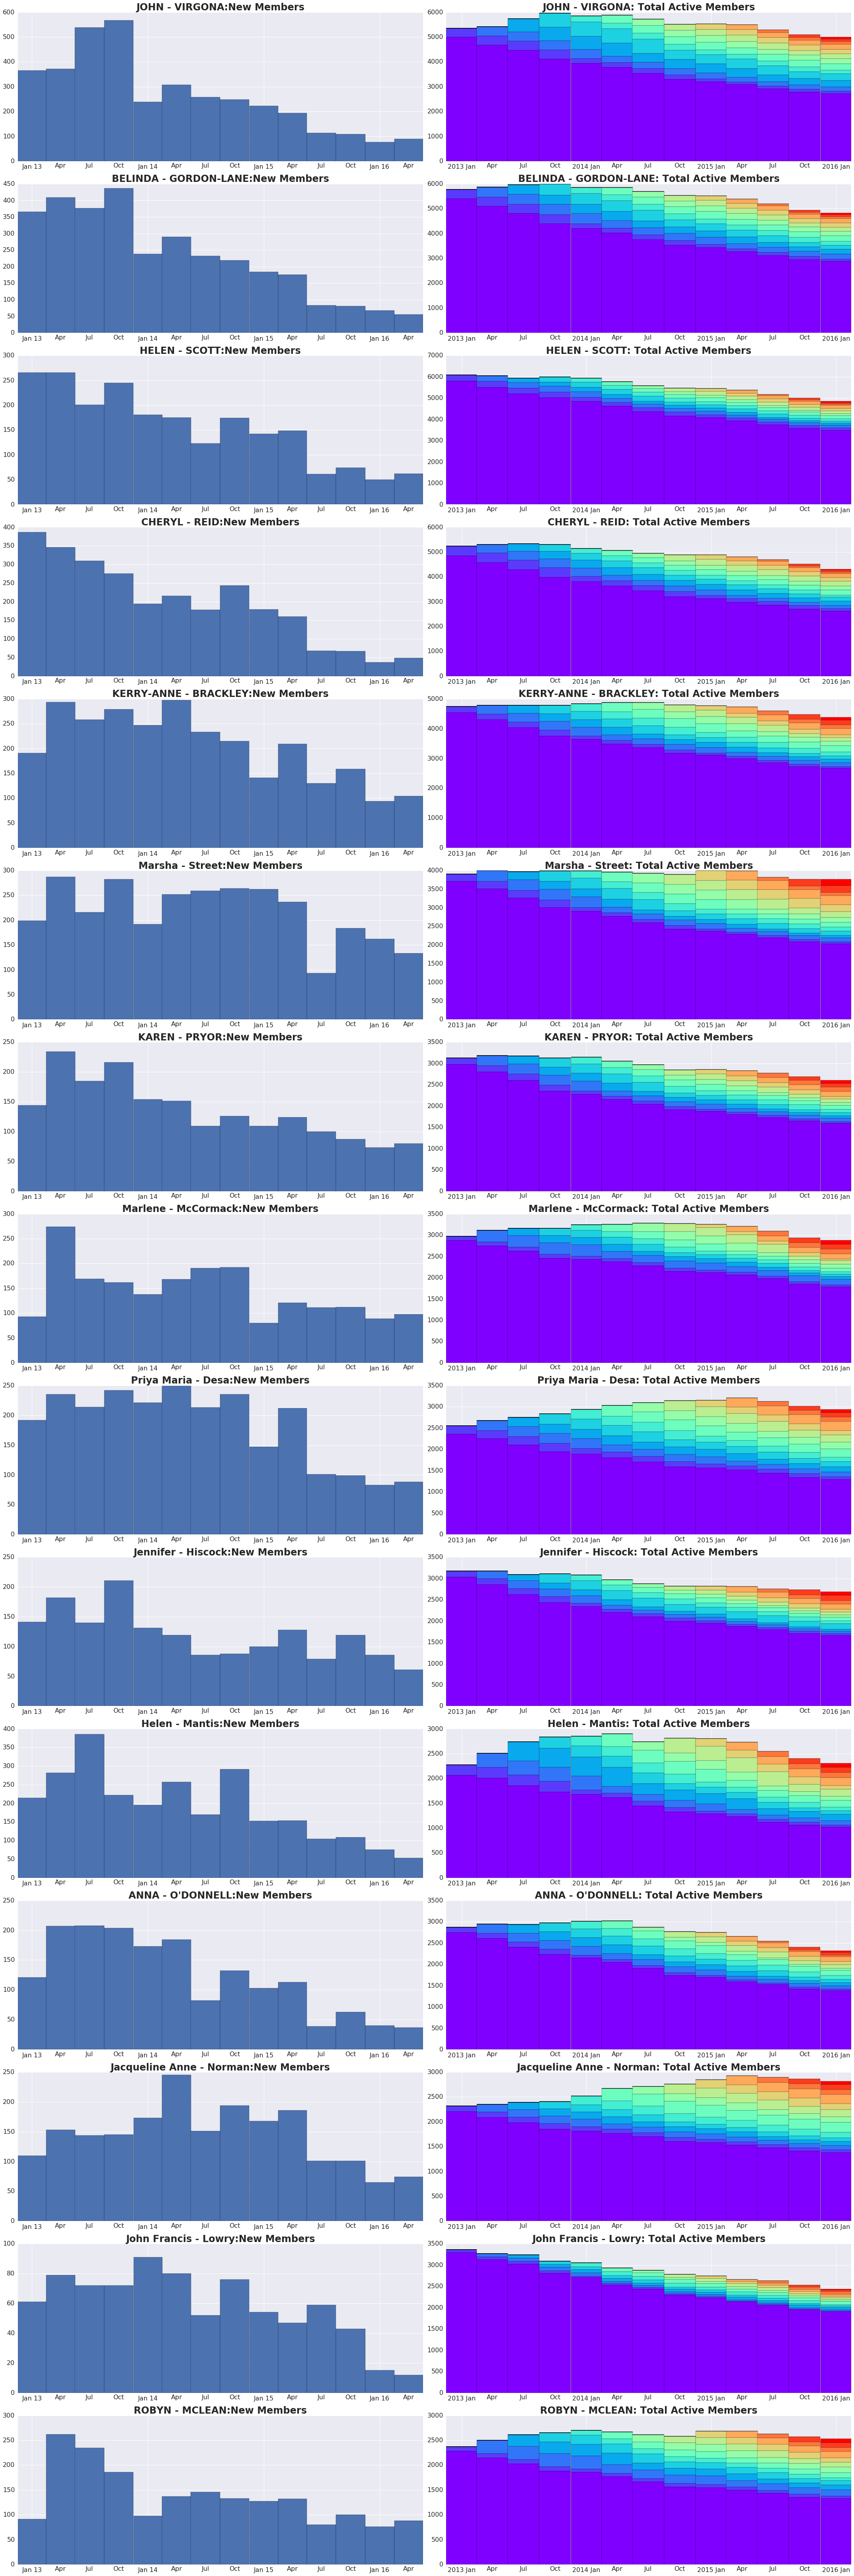

In [0]:
num=15
segment = members[members['Country'] == 'AU']
employees = segment.groupby('Employee', gl.aggregate.COUNT).topk('Count', k=num+1)[1:]['Employee']
fig, grid = plt.subplots(num,2, figsize=(30,6*num))
for employee, axes in zip(employees, grid):
    emp_members = segment[segment['Employee'] == employee]
    
    tl.plot_new_sales(emp_members, dt.datetime(2013, 1, 1), window=3, title=employee + ':New Members', y='Count', ax=axes[0])
    tl.plot_cohorts(emp_members, dt.datetime(2013, 1, 1), end=dt.datetime(2016, 4, 1),window=3, 
                    title=employee + ': Total Active Members', ax=axes[1])
   
plt.tight_layout()

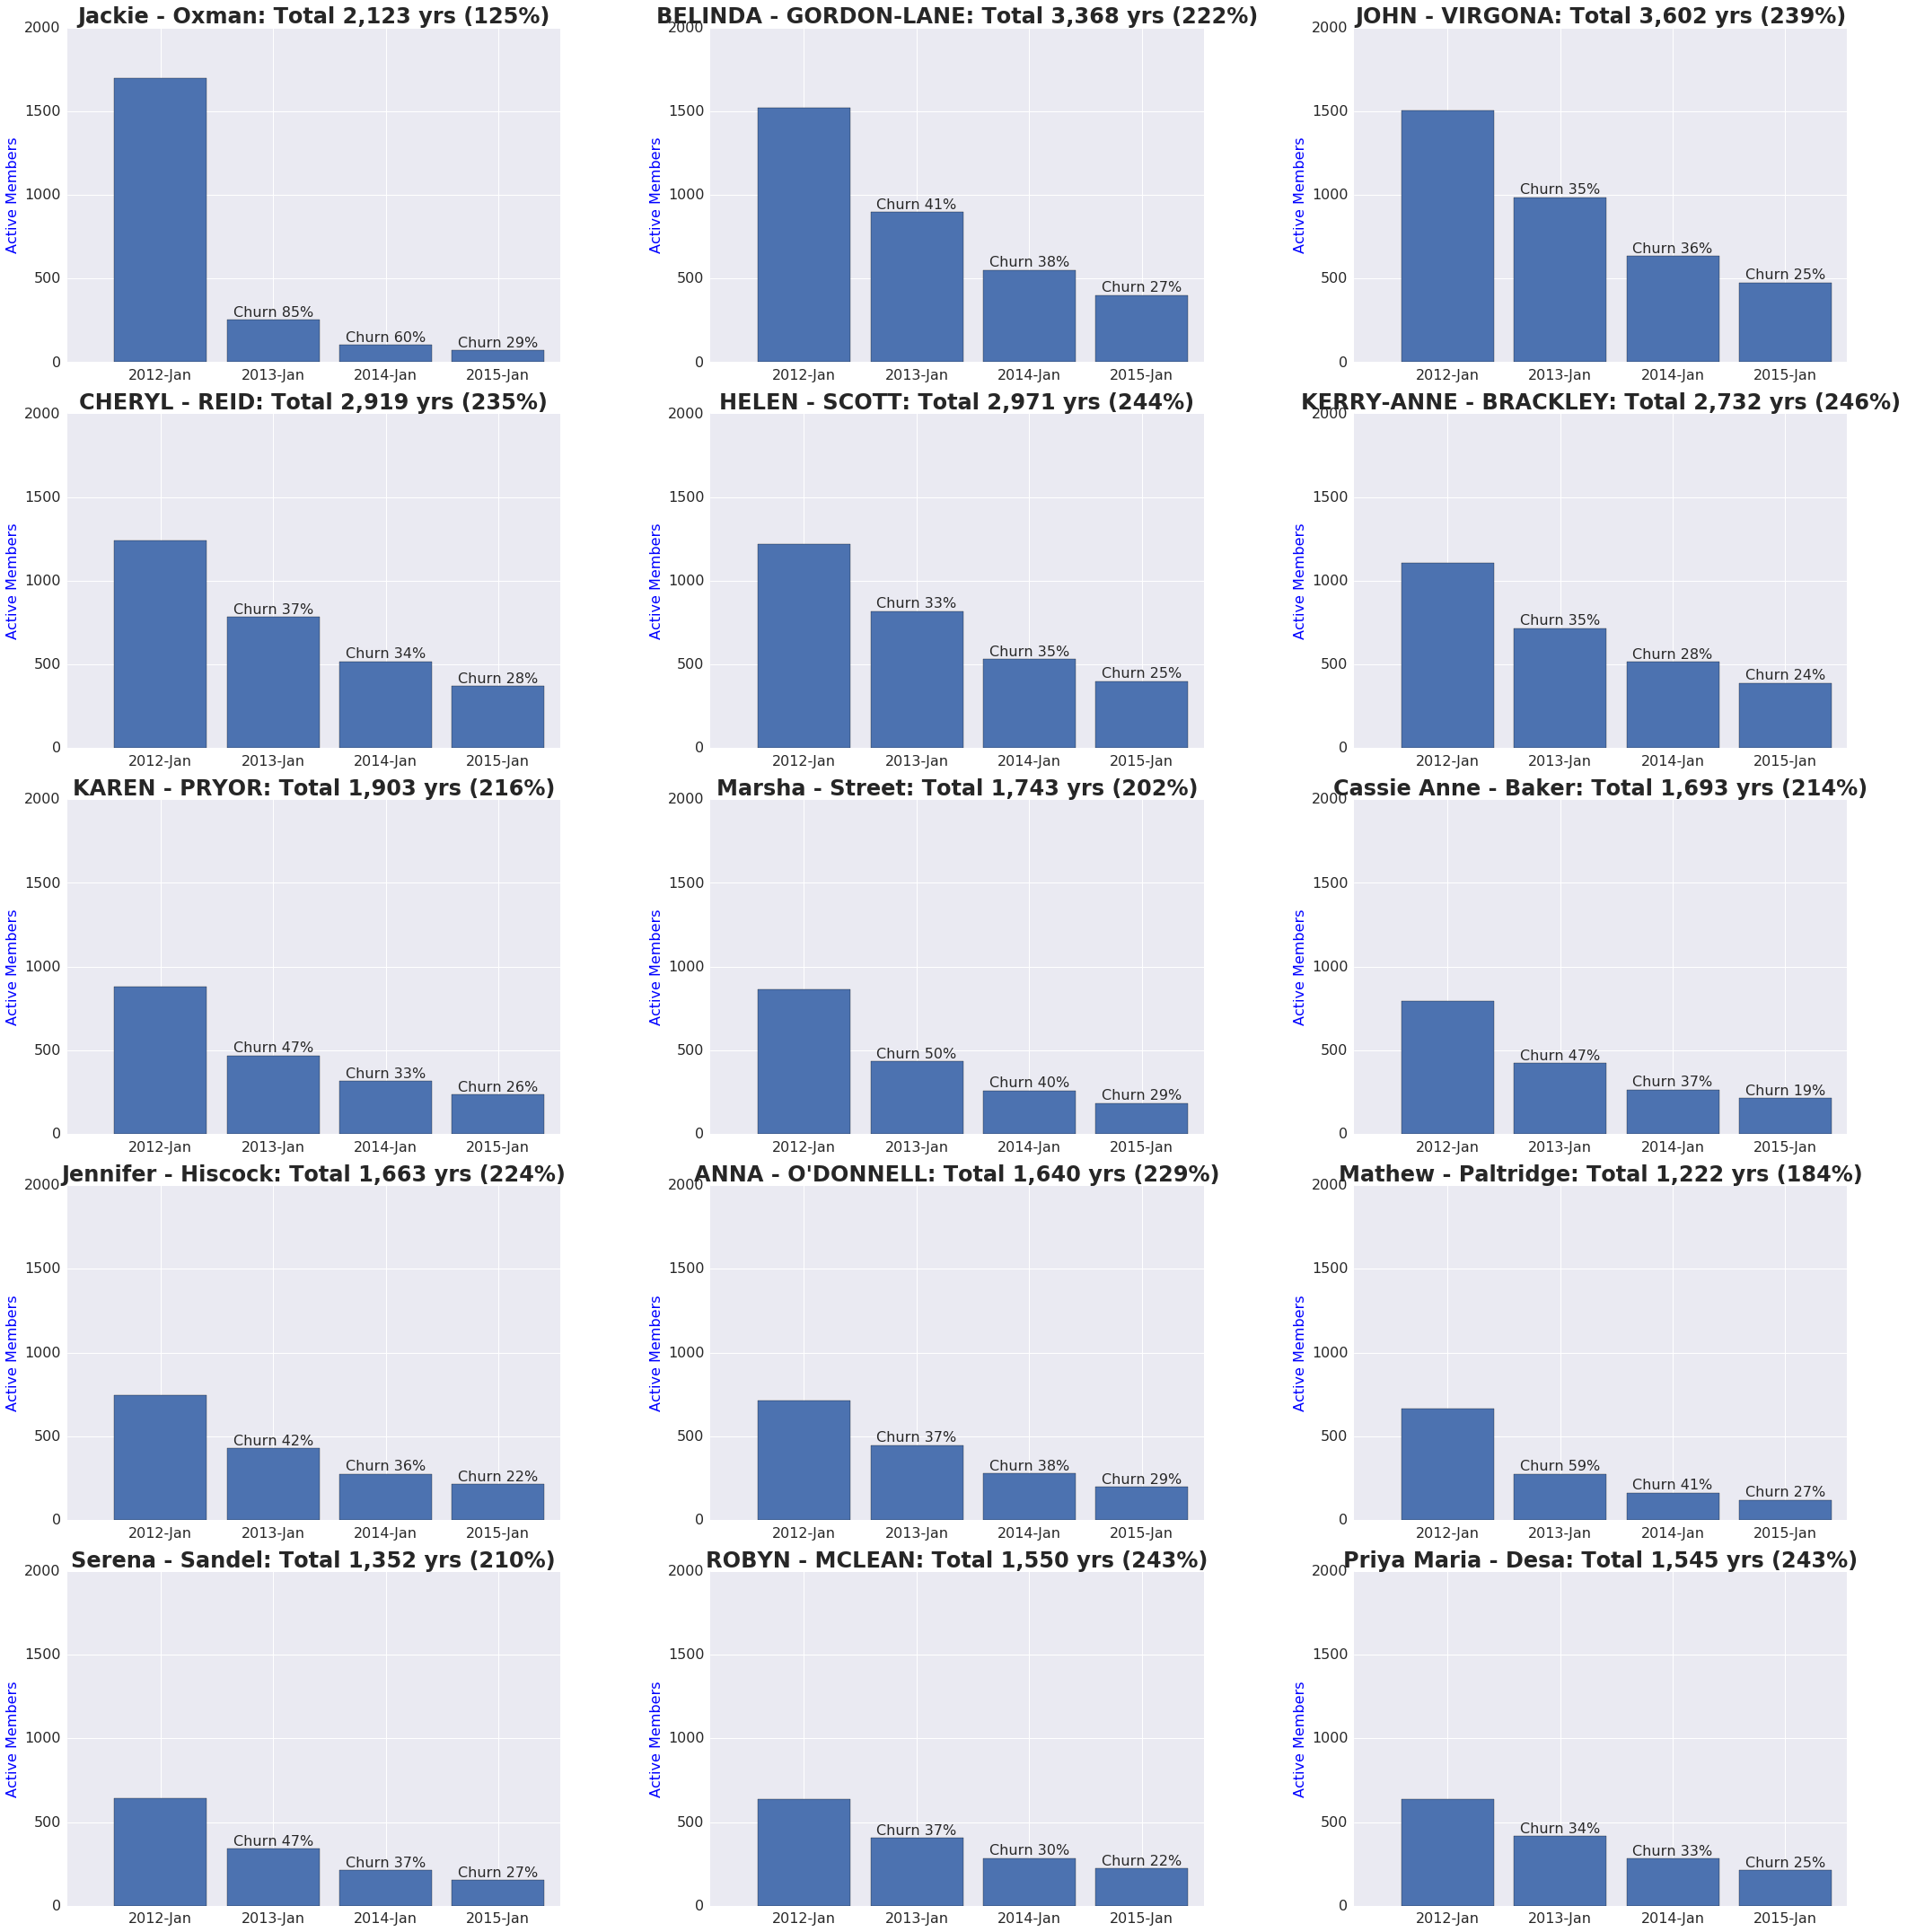

In [0]:
segment = members[members['Country'] == 'AU']
fig, axes = plt.subplots(5,3, figsize=(30,6*5))
year=2012
start =dt.datetime(year, 1, 1)
employee = tl.cohort(segment, 'MEMBER_SINCE',start, window=12).groupby('Employee', gl.aggregate.COUNT).sort('Count', ascending=False)
employee = employee.topk('Count', k=16)

for ax, employee in zip(axes.flat, employee['Employee']):
        segment= members[(members['Employee'] == employee)]

        r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',dt.datetime(2012, 1, 1) , window=12)    
        tl.plot_retention(r, "{}".format(employee), ax)
        ax.set_ylim(0, 2000)
plt.tight_layout()

## China

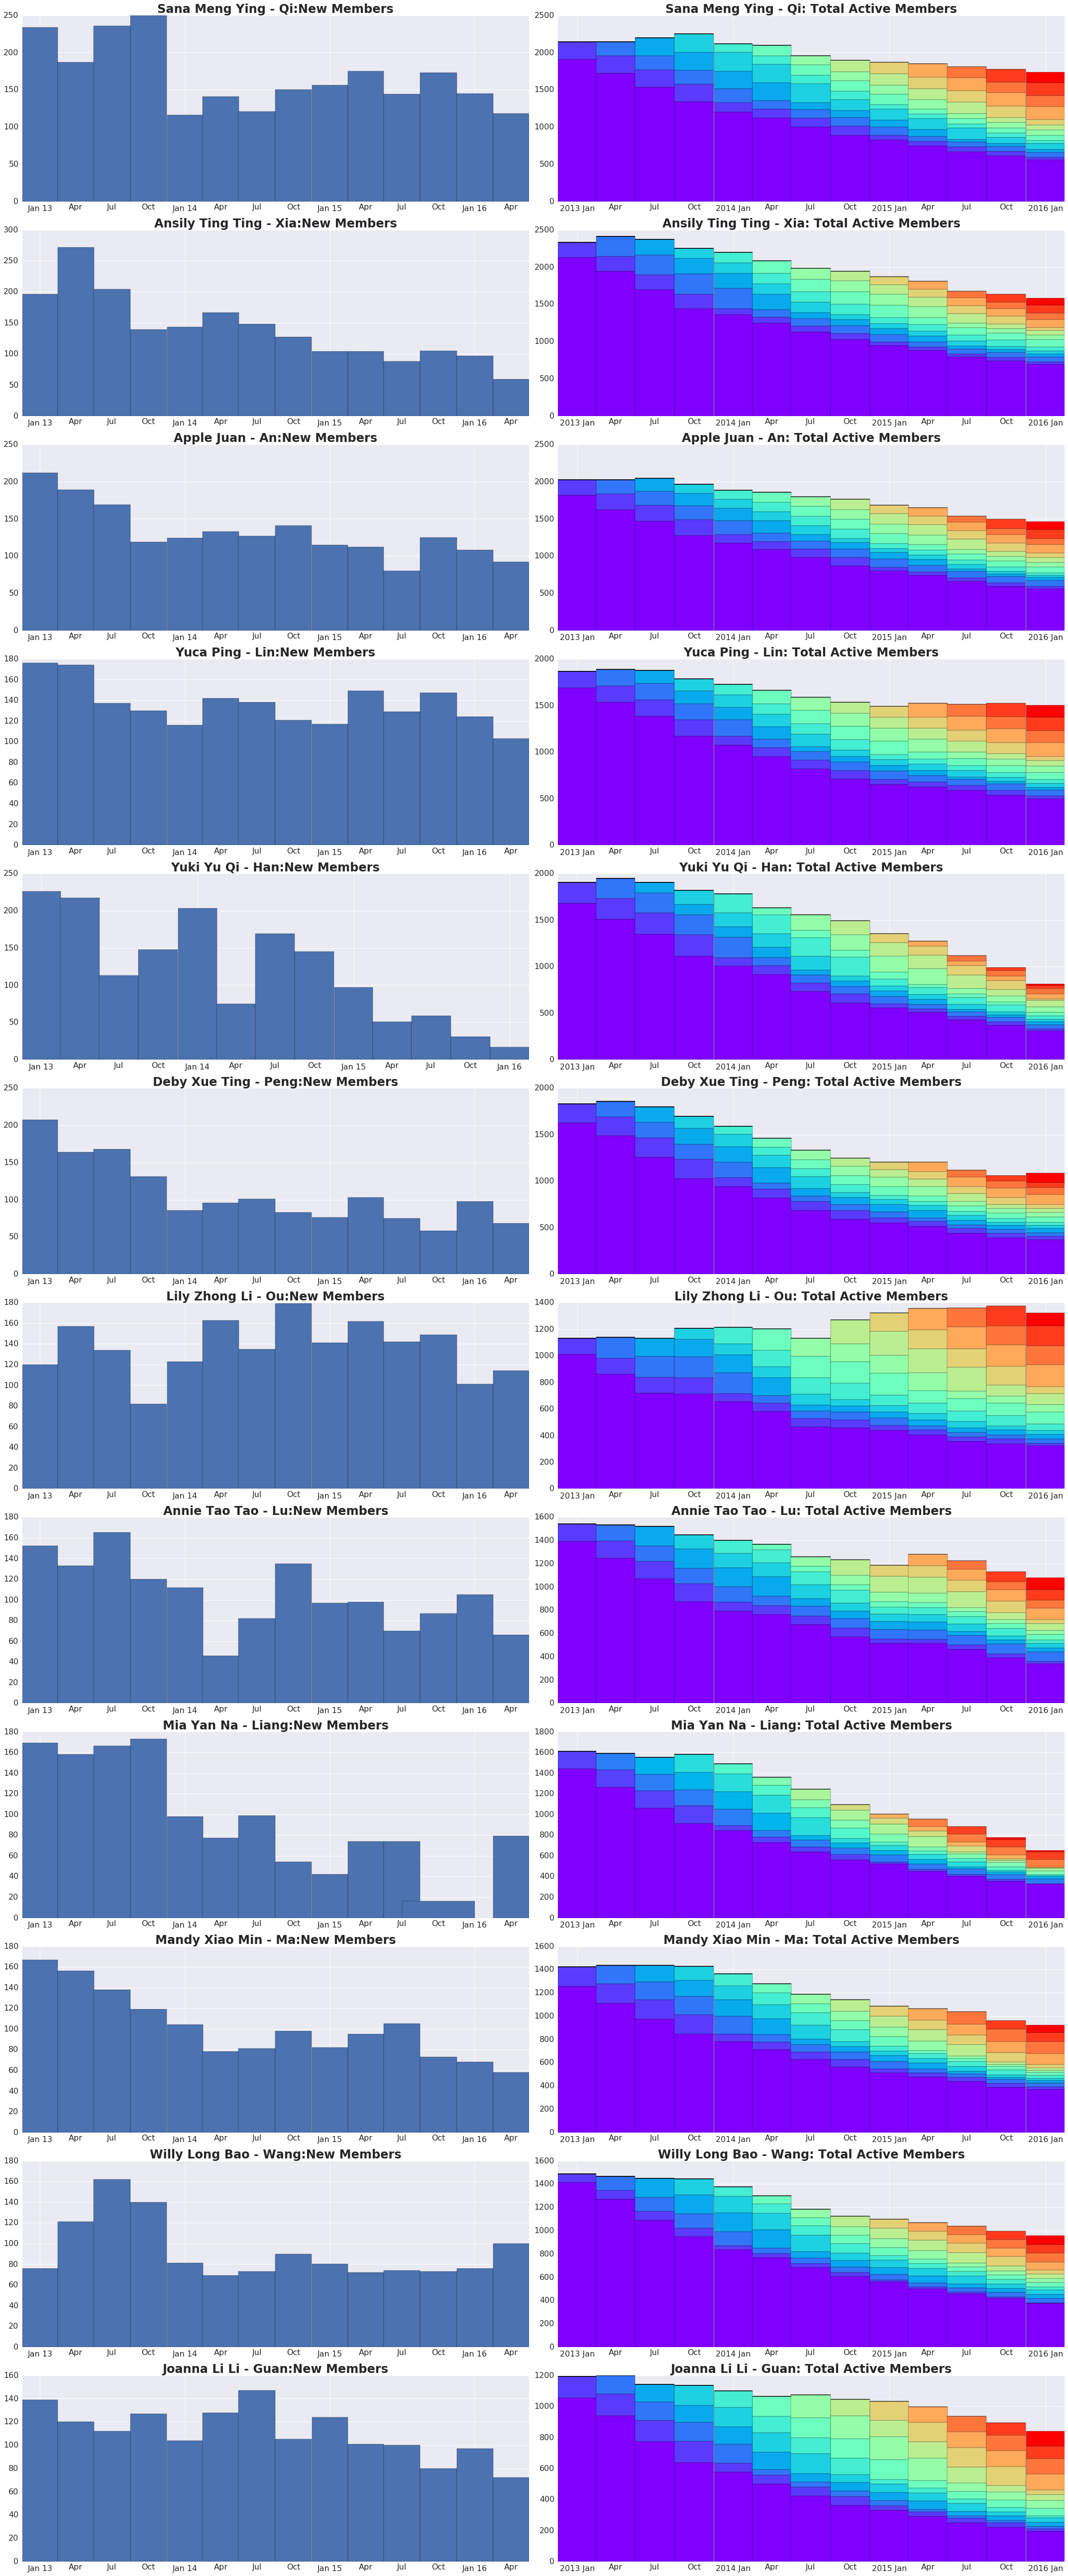

In [0]:
num=12
segment = members[members['Country'] == 'CN']
employees = segment.groupby('Employee', gl.aggregate.COUNT).topk('Count', k=num+1)[1:]['Employee']
fig, grid = plt.subplots(num,2, figsize=(30,6*num))
for employee, axes in zip(employees, grid):
    emp_members = segment[segment['Employee'] == employee]
    
    tl.plot_new_sales(emp_members, dt.datetime(2013, 1, 1), window=3, title=employee + ':New Members', y='Count', ax=axes[0])
    tl.plot_cohorts(emp_members, dt.datetime(2013, 1, 1), end=dt.datetime(2016, 4, 1),window=3, 
                    title=employee + ': Total Active Members', ax=axes[1])
   
plt.tight_layout()

Is the poor retention rates of Yuki Yu Qi in year 3 and Precilla in year 2 an indicate they left?

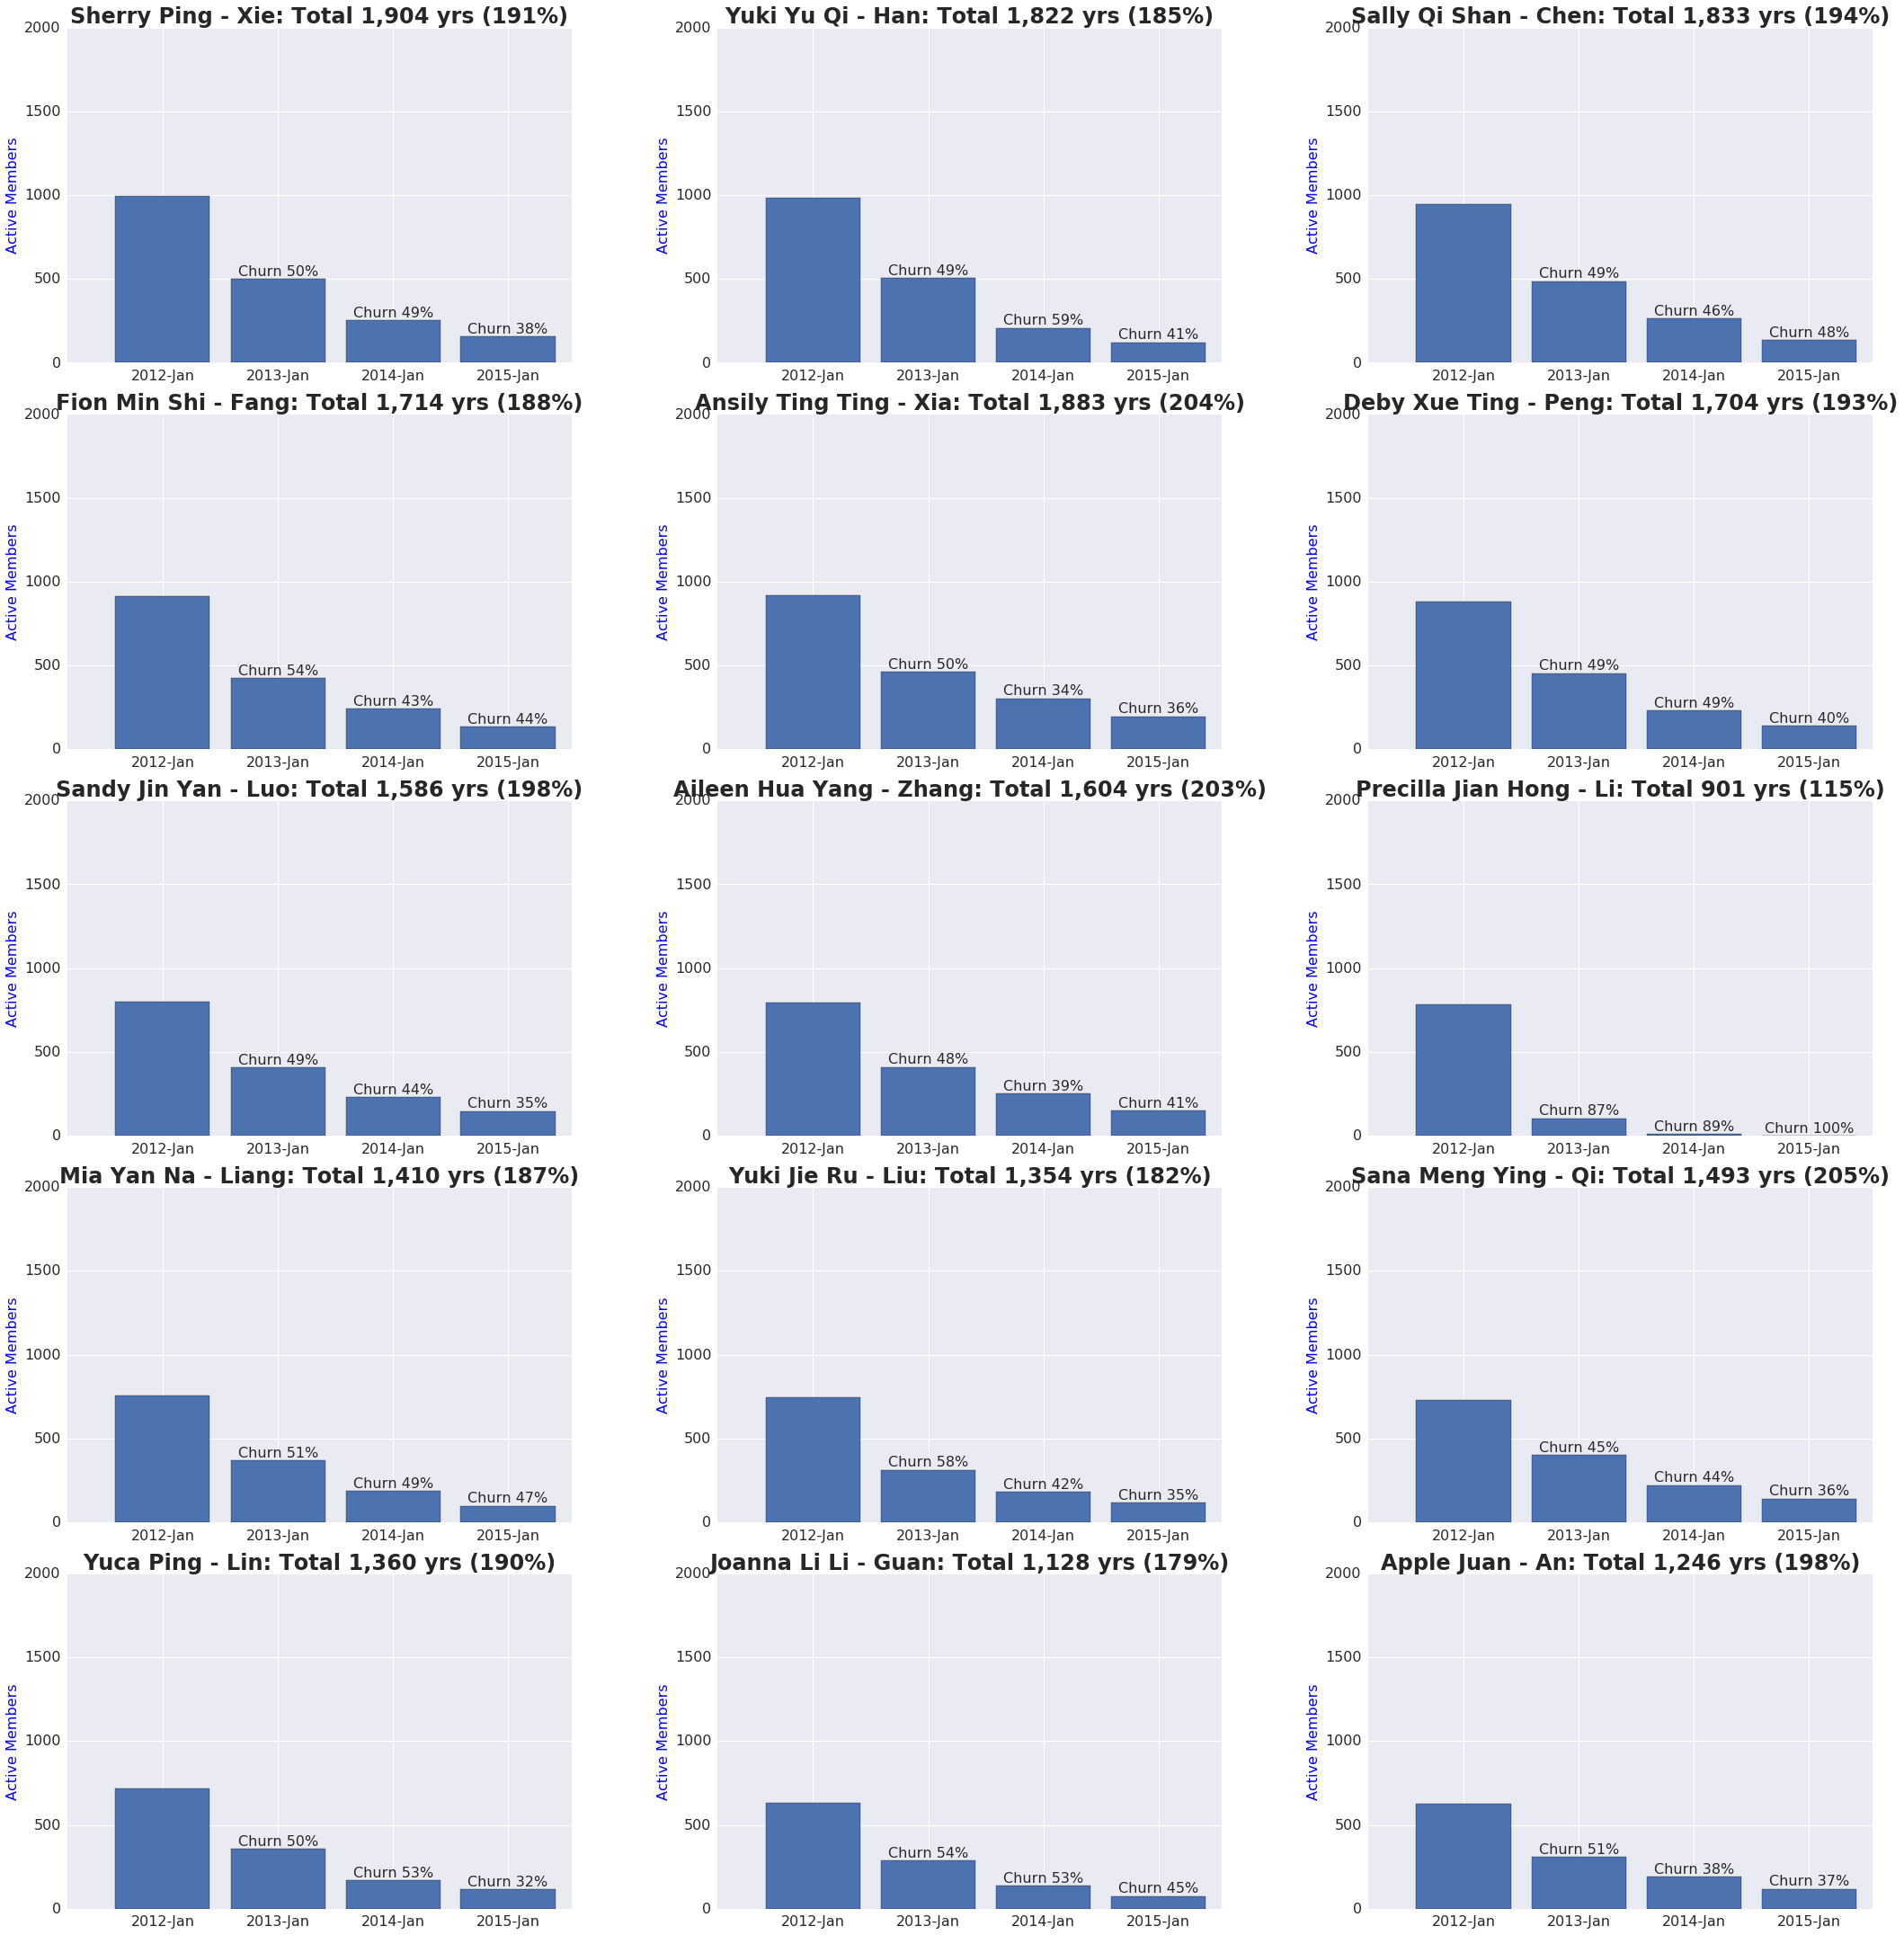

In [0]:
segment = members[members['Country'] == 'CN']
fig, axes = plt.subplots(5,3, figsize=(30,6*5))
year=2012
start =dt.datetime(year, 1, 1)
employee = tl.cohort(segment, 'MEMBER_SINCE',start, window=12).groupby('Employee', gl.aggregate.COUNT).sort('Count', ascending=False)
employee = employee.topk('Count', k=16)

for ax, employee in zip(axes.flat, employee['Employee']):
        segment= members[(members['Employee'] == employee)]

        r = tl.retention(segment, 'MEMBER_SINCE', 'END_DATE',dt.datetime(2012, 1, 1) , window=12)    
        tl.plot_retention(r, "{}".format(employee), ax)
        ax.set_ylim(0, 2000)
plt.tight_layout()